# Analysis of our data

1. Data collecting 
2. Data cleaning 
2. Machine Learning
3. Graph creation
4. Analysis

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from pandas.io.json import json_normalize
import pickle
import re
import scipy as sp
import scipy.sparse as sprs
from scipy import stats
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import validation_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
pd.options.mode.chained_assignment = None
import datetime
import nltk
import networkx as nx
import omdb


In [2]:
%matplotlib inline

In [3]:
#import dataset
FILE_PATH_CREW = "Data/tmdb_5000_credits.csv"
features_crew = pd.read_csv(FILE_PATH_CREW)

# Dataframe with info about the movies
features_crew.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


# 1. Data collecting

The data was collected from the OMDb API. It was saved in 'metacrit.p'. In order to collect this data, we used the Title from each movie in the TMDb 5000 credits dataset ('/Data/tmdb_5000_credits.csv'). 

In [5]:
# Specify the API_KEY used to set client
API_y_KEY = 'mykey'
omdb.set_default('apikey', API_y_KEY)
client = omdb.OMDBClient(apikey=API_y_KEY)

In [6]:
# We have a 1000 request limit so you can decide here at which film you want to start and where to end 
id_end = 4803
id_start = id_end - 1000

In [7]:
# Creates empty dictionary then updates it using the movie_id as a key and the output of the
# request as value (note that that res.content isn't actually a dict but a byte object, we may
# need to convert it later)

collected = dict()

for i in range(id_start, id_end):
    title = features_crew.title[i]
    res = omdb.request(t=title, tomatoes=True)
    movie_json = res.content
    collected[str(features_crew.movie_id[i])] = movie_json

In [8]:
# Caves collected as pickle
with open('Data/metacrit.p', 'wb') as fp:
    pickle.dump(collected, fp, protocol=pickle.HIGHEST_PROTOCOL)

# 2. Data cleaning

Here, we take the collected data from the API and create a working dataframe with one feature per column. 
Then, we remove the unwanted columns.
Finally, we format and clean the remaining features to make them exploitable and drop the NaN values.

In [8]:
# Loads collected
with open('Data/metacrit.p', 'rb') as fp:
    test_data = pickle.load(fp)

In [9]:
df = pd.DataFrame.from_dict(test_data, orient='index')
df.head()

,0
19995,"b'{""Title"":""Avatar"",""Year"":""2009"",""Rated"":""PG-..."
285,"b'{""Title"":""Pirates of the Caribbean: At World..."
206647,"b'{""Title"":""Spectre"",""Year"":""2015"",""Rated"":""PG..."
49026,"b'{""Title"":""The Dark Knight Rises"",""Year"":""201..."
49529,"b'{""Title"":""John Carter"",""Year"":""2012"",""Rated""..."


In [10]:
dataframe = pd.read_json(df.iloc[0].values[0])

for i in range(1, len(df)):
    if len(df.iloc[i].values[0]) > 100:
        movie = pd.read_json(df.iloc[i].values[0])
    dataframe = pd.concat([dataframe, movie])

## 2.1 Dropping columns

We decided to drop the useless columns that did not contain information about the movie
These columns are: - urls (Poster, Website, tomatoImage)
                   - columns related to the API (Response, Type)
                   - columns where all entries are NaN
                   - Irrelevant columns (Released, Year, DVD, totalSeasons)
                   - Redundant columns (imdbID is redundant with Title)

In [11]:
dataframe = dataframe.drop(columns=['Poster', 'Response', 'Type', 'Website', 'tomatoConsensus', 
                                    'tomatoFresh', 'tomatoImage', 'tomatoMeter', 'tomatoRating', 
                                    'tomatoReviews', 'tomatoRotten', 'tomatoURL', 'tomatoUserMeter', 
                                    'tomatoUserRating', 'tomatoUserReviews', 'totalSeasons', 'DVD',
                                    'Year', 'Released', 'imdbID'])
dataframe.head()

,Actors,Awards,BoxOffice,Country,Director,Genre,Language,Metascore,Plot,Production,Rated,Ratings,Runtime,Title,Writer,imdbRating,imdbVotes
0,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,"$749,700,000","UK, USA",James Cameron,"Action, Adventure, Fantasy, Sci-Fi","English, Spanish",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Internet Movie Database', 'Value':...",162 min,Avatar,James Cameron,7.8,"1,013,715"
1,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,"$749,700,000","UK, USA",James Cameron,"Action, Adventure, Fantasy, Sci-Fi","English, Spanish",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Rotten Tomatoes', 'Value': '82%'}",162 min,Avatar,James Cameron,7.8,"1,013,715"
2,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,"$749,700,000","UK, USA",James Cameron,"Action, Adventure, Fantasy, Sci-Fi","English, Spanish",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Metacritic', 'Value': '83/100'}",162 min,Avatar,James Cameron,7.8,"1,013,715"
0,"Johnny Depp, Geoffrey Rush, Orlando Bloom, Kei...",Nominated for 2 Oscars. Another 20 wins & 44 n...,"$309,404,152",USA,Gore Verbinski,"Action, Adventure, Fantasy",English,50,"Captain Barbossa, Will Turner and Elizabeth Sw...",Buena Vista,PG-13,"{'Source': 'Internet Movie Database', 'Value':...",169 min,Pirates of the Caribbean: At World's End,"Ted Elliott, Terry Rossio, Ted Elliott (charac...",7.1,"542,125"
1,"Johnny Depp, Geoffrey Rush, Orlando Bloom, Kei...",Nominated for 2 Oscars. Another 20 wins & 44 n...,"$309,404,152",USA,Gore Verbinski,"Action, Adventure, Fantasy",English,50,"Captain Barbossa, Will Turner and Elizabeth Sw...",Buena Vista,PG-13,"{'Source': 'Rotten Tomatoes', 'Value': '44%'}",169 min,Pirates of the Caribbean: At World's End,"Ted Elliott, Terry Rossio, Ted Elliott (charac...",7.1,"542,125"


## 2.2 Transform to numerical (runtime, box office, metascore, imdbVotes) 

We now need to transform the types so that it is easier to analyze the features. As of now, almost all the entries of our dataframe are strings. We have a few entries that are integer numbers that need to be converted: BoxOffice, Metascore, Runtime and imdbVotes.

Metascore is already in an appropriate format, we just need to cast the type. However, BoxOffice, Runtime and imdbVotes need a little bit of tinkering.

In [12]:
# For Runtime we need to remove the ' min'
dataframe['Runtime'] = dataframe['Runtime'].apply(lambda x: x.replace(" min", ""))
dataframe['Runtime'] = dataframe['Runtime'].replace('N/A', np.nan)
dataframe['Runtime'] = dataframe['Runtime'].astype(float)
dataframe = dataframe.dropna()
dataframe['Runtime'] = dataframe['Runtime'].astype(int)
# For BoxOffice we need to remove the $ and commas
dataframe['BoxOffice'] = dataframe['BoxOffice'].apply(lambda x: x.replace("$", ""))
dataframe['BoxOffice'] = dataframe['BoxOffice'].apply(lambda x: x.replace(",", ""))
dataframe['BoxOffice'] = dataframe['BoxOffice'].replace('N/A', np.nan)
dataframe['BoxOffice'] = dataframe['BoxOffice'].astype(float)
dataframe = dataframe.dropna()
dataframe['BoxOffice'] = dataframe['BoxOffice'].astype(int)
# Metascore
dataframe['Metascore'] = dataframe['Metascore'].replace('N/A', np.nan)
dataframe = dataframe.dropna()
dataframe['Metascore'] = dataframe['Metascore'].astype(int)
# for imdbVotes we need to remove the commas
dataframe['imdbVotes'] = dataframe['imdbVotes'] .str.replace(',', '')
dataframe['imdbVotes'] = dataframe['imdbVotes'] .astype(float)
dataframe['imdbVotes'] = dataframe['imdbVotes'] .replace(np.nan, 0)

## 2.3 Transform grades (IMDb, Rotten Tomatoes, Metacritic)

Now, we need to regroup the different sources of ratings so that the movies are not repeated three times in the dataframe.

- The first rating comes from imdb, its value is on a scale from 0 to 10
- The second rating comes from Rotten Tomatoes, its value is a percentage
- The third rating comes from Metacritic, its value is on a scale from 0 to 100

We wish to separate this column into 3 columns, drop the duplicate rows and convert the ratings to percentages for a more uniform notation.

In [13]:
dataframe_ = dataframe.copy()

In [14]:
def transform_tomatograde(strgrade):
    if '/10' in strgrade:
        grade = strgrade.replace('/10', '').replace('.', '')
    elif '%' in strgrade:
        grade = strgrade.replace('%', '')
    elif '/100' in dataframe_['metacriticGrade'][i]:
        grade = strgrade.replace('/100', '')
    else:
        grade = float(dataframe_['tomatoGrade'][i])
    grade = float(grade)
    if grade > 100:
        grade = grade / 10
    return int(grade)   

In [15]:
# 1. Extract the Rotten Tomatoes grade
dataframe_['RatingIndex'] = dataframe_.index
dataframe_ = dataframe_.reset_index(drop=True)
dataframe_['tomatoGrade'] = np.nan
for i in range(len(dataframe_[dataframe_.RatingIndex == 1])):
    title = dataframe_[dataframe_.RatingIndex == 1].iloc[i].Title
    idx = dataframe_[dataframe_.Title == title].index[0]
    grade = transform_tomatograde(dataframe_[dataframe_.RatingIndex == 1].iloc[i].Ratings['Value'])
    dataframe_.at[idx, 'tomatoGrade'] = grade
dataframe_ = dataframe_[dataframe_.RatingIndex == 0]
dataframe_ = dataframe_.drop(columns=['RatingIndex'])

# 2. Rename the Metacritics and imdb grades
dataframe_ = dataframe_.rename(columns={'imdbRating' : 'imdbGrade', 'Metascore' : 'metacriticGrade'})

# 3. Drop NaN
dataframe_ = dataframe_.dropna()

# 4. Transform grades
dataframe_['imdbGrade'] = dataframe_['imdbGrade']*10
dataframe_['imdbGrade'] = dataframe_['imdbGrade'].astype(int)
dataframe_['tomatoGrade'] = dataframe_['tomatoGrade'].astype(int)
dataframe_['metacriticGrade'] = dataframe_['metacriticGrade'].astype(int)

# 5. Reset index
dataframe_ = dataframe_.reset_index(drop=True)

# 6. Drop the Ratings column
dataframe_ = dataframe_.drop(columns=['Ratings'])

## 2.4 Make sets out of categorical features (country, language, actors, director, writer)

Now, we need to deal with the string attributes that are in form of a list. We want a set of strings, each string corresponding to an individual characteristic (country, actor, etc).

In order to do so, we split the string at the commas. For the Writer attribute, we decided to remove the specifications and only keep the names of the writers, taking off who wrote the story, screenplay or characters.

In [16]:
dataframe_['Country'] = dataframe_['Country'].apply(lambda x: set(x.split(', ')))
dataframe_['Language'] = dataframe_['Language'].apply(lambda x: set(x.split(', ')))

In [17]:
dataframe_['Actors'] = dataframe_['Actors'].apply(lambda x: set(x.split(', ')))
dataframe_['Director'] = dataframe_['Director'].apply(lambda x: set(x.split(', ')))
dataframe_['Genre'] = dataframe_['Genre'].apply(lambda x: set(x.split(', ')))
dataframe_['Writer'] = dataframe_['Writer'].apply(lambda x: re.sub(" [\(\[].*?[\)\]]", "", x))
dataframe_['Writer'] = dataframe_['Writer'].apply(lambda x: set(x.split(', ')))

## 2.5 Add numerical features to categorical features for regression (actors, writers, directors)

Some features cannot be used as they are for regression. For instance, actors, directors writers cannot be one-hot encoded as this will make the number of features exceed the number of samples. Our solution is to use the BoxOffice generated by these crew members (by every film where they participated) and cumulate it to give a measure for their success.

In [18]:
# We take the relevant columns
crew_act = dataframe_.loc[:,['Actors', 'Title']]
crew_dir = dataframe_.loc[:,['Director', 'Title']]
crew_writ = dataframe_.loc[:,['Writer', 'Title']]

# For now each dataframe cell contains a set of strings. This is quite difficult to separate so we transform
# each one of them into a string and separate each name from another with a ", "
crew_act.Actors = crew_act.Actors.apply(lambda x: ', '.join(list(x)))
crew_dir.Director = crew_dir.Director.apply(lambda x: ', '.join(list(x)))
crew_writ.Writer = crew_writ.Writer.apply(lambda x: ', '.join(list(x)))

# Now that we have a dataframe of strings se separate all the crew members' names and put them in consecutive
# rows duplicating whatever in the other columns
crew_act = pd.DataFrame(crew_act.Actors.str.split(', ').tolist(), index=crew_act.Title).stack()
crew_act = crew_act.reset_index()[[0, 'Title']]
crew_act.columns = ['Actor', 'Title']

crew_dir = pd.DataFrame(crew_dir.Director.str.split(', ').tolist(), index=crew_dir.Title).stack()
crew_dir = crew_dir.reset_index()[[0, 'Title']]
crew_dir.columns = ['Director', 'Title']

crew_writ = pd.DataFrame(crew_writ.Writer.str.split(', ').tolist(), index=crew_writ.Title).stack()
crew_writ = crew_writ.reset_index()[[0, 'Title']]
crew_writ.columns = ['Writer', 'Title']

crew_writ.head()

,Writer,Title
0,James Cameron,Avatar
1,Jay Wolpert,Pirates of the Caribbean: At World's End
2,Ted Elliott,Pirates of the Caribbean: At World's End
3,Stuart Beattie,Pirates of the Caribbean: At World's End
4,Terry Rossio,Pirates of the Caribbean: At World's End


In [19]:
# Here we collect all relevant information in a temporary dataframe
dataframe_tmp = dataframe_.loc[:,['Title', 'BoxOffice', 'Actors', 'Director', 'Writer']]
dataframe_tmp.columns = ['Title', 'BoxOffice', 'Actors', 'Directors', 'Writers']

# And now we join it based on the title of the movie with each of the actors, directors and writers
# dataframes
crew_act = pd.merge(crew_act, dataframe_tmp, on='Title')[['Actor', 'BoxOffice']]
# We aggregate the dataframe by actor name and sum the BoxOffices generated in each film where they
# played
crew_act = crew_act.groupby('Actor').agg({"BoxOffice": 'sum'})
crew_act.rename(columns={'Actor': 'BoxOffice'}, inplace=True)
crew_act.reset_index(inplace=True)

crew_dir = pd.merge(crew_dir, dataframe_tmp, on='Title')[['Director', 'BoxOffice']]
crew_dir = crew_dir.groupby('Director').agg({"BoxOffice": 'sum'})
crew_dir.rename(columns={'Director': 'BoxOffice'}, inplace=True)
crew_dir.reset_index(inplace=True)

crew_writ = pd.merge(crew_writ, dataframe_tmp, on='Title')[['Writer', 'BoxOffice']]
crew_writ = crew_writ.groupby('Writer').agg({"BoxOffice": 'sum'})
crew_writ.rename(columns={'Writer': 'BoxOffice'}, inplace=True)
crew_writ.reset_index(inplace=True)

del dataframe_tmp

crew_writ.head()

,Writer,BoxOffice
0,A.A. Milne,44701110.0
1,A.E.W. Mason,18236897.0
2,A.J. Quinnell,77600000.0
3,Aaron Covington,81157671.0
4,Aaron Guzikowski,127452303.0


## 2.7 Set the Production companies to standard names

Now, we deal with the Production company. We have observed that a same company has different names within this dataset, sometimes the names diferring only by a space or an add-on (like "distribution"). We want to uniformize this.

In [20]:
to_remove = [' Corporation', ' Distribution', ' Corporat', ' Production', ' Films', ' Film', 
             ' Pictures', ' Picutres', ' Internationa', ' International', ' Industries', ' Compa', 
             ' Co', ' Distribu', ' Studios', ' Animation', ' Feature', ' SKG', ' LLC', ' Recommends', 
             ' Digital', ' Media', ' Video', ' Inc', ' Home Entertainment', ' Entertainment', ' Lorber', 
             ' Releasing', ' Cinema.', ' Cinema', ' Classics', ' Classic', ' Group', ' Europacorp', 
             ' Pvt. Ltd.', ' Ventures', ' [us]', ' Pictur', ' Home', ' Focus', ' City', ' Atomic', 
             ' Faith', ' Searchlight', ' Walden', '.', ' TriStarl', ' TriStar', ' Tristar']
for word in to_remove:
    dataframe_['Production'] = dataframe_['Production'].str.replace(word, '')

In [21]:
dataframe_['Production'] = dataframe_['Production'].str.replace('-', ' ')
dataframe_['Production'] = dataframe_['Production'].str.replace(' / ', '/')
dataframe_['Production'] = dataframe_['Production'].str.replace(' /', '/')
dataframe_['Production'] = dataframe_['Production'].str.replace('/ ', '/')
dataframe_['Production'] = dataframe_['Production'].str.replace('DreamWorks', 'Dreamworks')
dataframe_['Production'] = dataframe_['Production'].str.replace('Dream Works', 'Dreamworks')
dataframe_['Production'] = dataframe_['Production'].str.replace("Lion's Gate", 'Lionsgate')
dataframe_['Production'] = dataframe_['Production'].str.replace("Liongate", 'Lionsgate')
dataframe_['Production'] = dataframe_['Production'].str.replace("Lions Gate", 'Lionsgate')
dataframe_['Production'] = dataframe_['Production'].str.replace("LionsGate", 'Lionsgate')
dataframe_['Production'] = dataframe_['Production'].str.replace('Metro Goldwyn Mayer (MGM)', 'MGM')
dataframe_['Production'] = dataframe_['Production'].str.replace('Metro Goldwyn Mayer', 'MGM')
dataframe_['Production'] = dataframe_['Production'].str.replace('WARNER BROTHERS PICTURES', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('WB', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('Weinsteinny', 'Weinstein')
dataframe_['Production'] = dataframe_['Production'].str.replace('Warner Brothers', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('Warner Home', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('Warner Independent', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('PIXAR', 'Pixar')
dataframe_['Production'] = dataframe_['Production'].str.replace('Warners Bros', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('Universall', 'Universal')
dataframe_['Production'] = dataframe_['Production'].str.replace('The Weinstein', 'Weinstein')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Vantage', 'Weinstein')
dataframe_['Production'] = dataframe_['Production'].str.replace('/lumbia', '/ Columbia')
dataframe_['Production'] = dataframe_['Production'].str.replace('MGM (MGM)', 'MGM')
dataframe_['Production'] = dataframe_['Production'].str.replace(' First Take', '/ Columbia')
dataframe_['Production'] = dataframe_['Production'].str.replace('Goodbye Cruel', 'Goodbye Cruel World')
dataframe_['Production'] = dataframe_['Production'].str.replace('FoxFaith', 'Fox')
dataframe_['Production'] = dataframe_['Production'].str.replace('Fine Line', 'Fine Lines')
dataframe_['Production'] = dataframe_['Production'].str.replace('Erosl', 'Eros')
dataframe_['Production'] = dataframe_['Production'].str.replace('Walt Disneys', 'Disney')
dataframe_['Production'] = dataframe_['Production'].str.replace('Walt Disney', 'Disney')

In [22]:
dataframe_['Production'] = dataframe_['Production'].apply(lambda x: set(x.split('/')))

## 2.8 Select only nouns from plot and place them in a set

Now, we deal with the plot. For this NLP task, we will keep it simple. We only kept the common nouns (singular or plural).

In [23]:
def find_nouns(text):
    tokens = nltk.word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    nouns = [word for word,pos in tags if (pos == 'NN' or pos == 'NNS')]
    return set(nouns)

In [24]:
dataframe_['Plot'] = dataframe_['Plot'].apply(lambda x: find_nouns(x))

## 2.9 Extract the wins and nominations from the 'Awards' sentence

We need to format the Awards feature. The current Awards column contains a string (sentence) describing how many awards the movie has won or has been nominated to. It also specifies if it has won or been nominated to Oscars or BAFTA. We believe that when it is specified, the higher "award" is listed, i.e. if the movie won 2 Oscars, the 5 Oscar nominations won't be specified. The most useful format we could think of is to transform this award column into 2 distinct columns, since we cannot infer how many nominations to the Oscars a movie has when it has already won some. The columns are hence: 

- Wins
- Nominations

In [25]:
def find_wins_nominations(string):
    wins = 0
    noms = 0
    
    splitted = string.split('. ')
    if len(splitted) > 1:
        string1 = splitted[0]
        if re.search('nominated', string1, re.IGNORECASE):
            noms = noms + int(string1.split(' ')[2])
        if re.search('won', string1, re.IGNORECASE):
            wins = noms + int(string1.split(' ')[1])
        
        string2 = splitted[1]
        if re.search('nomination', string2, re.IGNORECASE):
            noms = noms + int(string2.split(' nomination')[0].split(' ')[-1])
        if re.search('win', string2, re.IGNORECASE):
            wins = wins + int(string2.split(' win')[0].split(' ')[-1])
    elif len(splitted) == 1:
        split_string = splitted[0]
        if re.search('nomination', split_string, re.IGNORECASE):
            noms = noms + int(split_string.split(' nomination')[0].split(' ')[-1])
        if re.search('win', split_string, re.IGNORECASE):
            wins = wins + int(split_string.split(' win')[0].split(' ')[-1])
    return wins, noms

In [26]:
dataframe_['Wins'] = 0
dataframe_['Nominations'] = 0

for i in range(0, len(dataframe_)):
    wins, noms = find_wins_nominations(dataframe_.Awards[i])
    dataframe_['Wins'][i] = wins
    dataframe_['Nominations'][i] = noms
dataframe_ = dataframe_.drop(columns='Awards')

## 2.10 Set the Rated categories to standard names

The Rated attribute is not uniform and has multiple conventions. We seek to normalize it. We decided to use the Motion Picture Association of America film rating system, which states that:

- **G: General Audiences. All ages admitted.** Nothing that would offend parents for viewing by children.
- **PG: Parental Guidance Suggested.** Some material may not be suitable for children. Parents urged to give "parental guidance". May contain some material parents might not like for their young children.
- **PG-13: Parents Strongly Cautioned.** Some material may be inappropriate for children under 13. Parents are urged to be cautious. Some material may be inappropriate for pre-teenagers.
- **R: Restricted. Under 17 requires accompanying parent or adult guardian.** Contains some adult material. Parents are urged to learn more about the film before taking their young children with them.
- **NC-17: Adults Only.** No One 17 and Under Admitted. Clearly adult. Children are not admitted.

https://en.wikipedia.org/wiki/Motion_Picture_Association_of_America_film_rating_system

**X** rating means persons under 16 not admitted. For our analysis, we decided to conflate that label within **NC-17**

Following this, we need to make some modifications: 

- Approved -> G
- GP -> PG
- M -> R
- Passed -> G
- TV-14 -> PG-13
- TV-G -> G
- TV-MA -> R
- TV-PG -> PG
- X -> NC-17
- Unrated, Not rated and N/A make up their own category **Unrated**

In [27]:
dataframe_['Rated'] = dataframe_['Rated'].str.replace('APPROVED', 'G')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('GP', 'PG')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('M', 'R')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('PASSED', 'G')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('TV-14', 'G')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('APPROVED', 'PG-13')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('TV-G', 'G')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('TV-MA', 'R')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('TV-PG', 'PG')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('X', 'NC-17')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('NOT RATED', 'UNRATED')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('N/A', 'UNRATED')

In [28]:
dataframe_['Rated'] = dataframe_['Rated'].apply(lambda x: {x})

## 2.11 Make categories for language: English, Spanish and Other

In order to make it easier to analyze, we decided to transform every foreign language into the label "Other" except from Spanish.

In [29]:
def format_languages(lang_set):
    if (lang_set - {'English', 'Spanish'}) != set(): # There are other things than English 
        if 'English' not in lang_set: # There is only other things than English
            if 'Spanish' not in lang_set:
                new_label = {'Other'}
            else: 
                new_label = {'Spanish', 'Other'}
        else:
            if 'Spanish' not in lang_set:
                new_label = {'English', 'Other'}
            else:
                new_label = {'English', 'Spanish', 'Other'}
    else:
        if 'English' not in lang_set:
            if 'Spanish' not in lang_set:
                new_label = set()
            else: 
                new_label = {'Spanish'}
        else:
            if 'Spanish' not in lang_set:
                new_label = {'English'}
            else:
                new_label = {'English', 'Spanish'}
    return new_label

dataframe_['Language'] = dataframe_['Language'].apply(lambda x: format_languages(x))

## 2.12 Make categories for countries: USA and Foreign

The countries are formatted so as to show 'USA' or 'Foreign'.

In [30]:
def format_country(country_set):
    if (country_set - {'USA'}) != set():
        if 'USA' not in country_set:
            new_label = {'Foreign'}
        else:
            new_label = {'USA', 'Foreign'}
    else:
        if 'USA' not in country_set:
            new_label = set()
        else:
            new_label = {'USA'}
    return new_label

dataframe_['Country'] = dataframe_['Country'].apply(lambda x: format_country(x))

In [31]:
dataframe_.to_pickle("Data/df.pkl")

In [32]:
dataframe_ = pd.read_pickle("Data/df.pkl")

## 2.13 Add the budget and normalise it to dollars instead of millions

Finally, we need to add the budget. For that, we use the budget column in the Kaggle imdb dataset.

In [33]:
FILE_PATH_MOVIE = "Data/tmdb_5000_movies.csv"
movie_df = pd.read_csv(FILE_PATH_MOVIE)

budget_df = movie_df[['budget', 'title']]
budget_df = budget_df.rename(columns={"budget" : "Budget", "title" : "Title"})

final_df = dataframe_.merge(budget_df, how='inner')

In [34]:
# Budget is weirdly formatted: there are movies that state a single number budget to signify its millions.
# Let's unify it

final_df['Budget'].iloc[1971] = final_df['Budget'].iloc[1971] * 10**6
final_df['Budget'].iloc[1608] = final_df['Budget'].iloc[1608] * 10**6
final_df['Budget'].iloc[2330] = final_df['Budget'].iloc[2330] * 10**6
final_df['Budget'].iloc[1861] = 5500000
final_df['Budget'].iloc[2310] = 650000
final_df['Budget'].iloc[764] = 45000000
final_df['Budget'].iloc[2349] = 153000

# Moreover, we have budgets that are 0. We will replace these as np.nan then drop the whole row
final_df['Budget'] = final_df['Budget'].apply(lambda x: np.nan if x==0 else x)

## 2.14 Drop Runtime

After removing all NaN values, we realized that all movies are feature movies (longer than 1 hour). We decided to drop this feature since it does not include short or medium-length movies. 

In [35]:
print('Number of movies shorter than 60 minutes:', len(final_df[final_df['Runtime'] < 60]))

Number of movies shorter than 60 minutes: 0


In [36]:
final_df = final_df.drop(columns=['Runtime'])

Drop NaN and reset index.

In [37]:
final_df = final_df.dropna()
final_df.reset_index(inplace=True)

In [38]:
final_df.to_pickle("Data/final_df.pkl")

## 2.15 Add the numerical categories for actors, writers and directors


Now it is time to add the new features related to BoxOffice generated by crew members to the corresponding movies.

In [39]:
dataframe_tmp = final_df.loc[:,['Actors','Director','Writer']]

We create empty dataframe containing either the set of actors, directors or writers followed with an empty column of zeros.

In [40]:
rev_act = final_df[['Actors']].copy()
rev_act['BoxOffice_actors'] = 0

rev_dir = final_df[['Director']].copy()
rev_dir['BoxOffice_directors'] = 0

rev_writ = final_df[['Writer']].copy()
rev_writ['BoxOffice_writers'] = 0

And then we go through each item in the set cumulating associated BoxOffice generated

In [41]:
for (s,set_) in enumerate(rev_act.Actors):
    for item_ in set_:
        rev_act.at[s, 'BoxOffice_actors'] = rev_act.at[s, 'BoxOffice_actors'].copy() + crew_act[crew_act['Actor']==item_].BoxOffice.copy()
        
for (s,set_) in enumerate(rev_dir.Director):
    for item_ in set_:
        rev_dir.at[s, 'BoxOffice_directors'] = rev_dir.at[s, 'BoxOffice_directors'].copy() + crew_dir[crew_dir['Director']==item_].BoxOffice.copy()     

for (s,set_) in enumerate(rev_writ.Writer):
    for item_ in set_:
        rev_writ.at[s, 'BoxOffice_writers'] = rev_writ.at[s, 'BoxOffice_writers'].copy() + crew_writ[crew_writ['Writer']==item_].BoxOffice.copy()      
  

And of course we end up by adding the new columns to our final_df

In [42]:
final_df['BoxOffice_actors'] = rev_act.BoxOffice_actors
final_df['BoxOffice_directors'] = rev_dir.BoxOffice_directors
final_df['BoxOffice_writers'] = rev_writ.BoxOffice_writers

final_df.to_pickle("Data/final_df.pkl")
final_df.head()

,index,Actors,BoxOffice,Country,Director,Genre,Language,metacriticGrade,Plot,Production,...,Writer,imdbGrade,imdbVotes,tomatoGrade,Wins,Nominations,Budget,BoxOffice_actors,BoxOffice_directors,BoxOffice_writers
0,0,"{Sam Worthington, Zoe Saldana, Sigourney Weave...",749700000,"{Foreign, USA}",{James Cameron},"{Sci-Fi, Adventure, Action, Fantasy}","{English, Spanish}",83,"{mission, moon, marine, home, orders, world}",{20th Century Fox},...,{James Cameron},78,1013715.0,82,88,128,237000000.0,4374612546,947816802,1173684544
1,1,"{Orlando Bloom, Geoffrey Rush, Johnny Depp, Ke...",309404152,{USA},{Gore Verbinski},"{Adventure, Action, Fantasy}",{English},50,"{treachery, map, betrayal, edge, battle, allia...",{Buena Vista},...,"{Jay Wolpert, Stuart Beattie, Terry Rossio, Te...",71,542125.0,44,20,46,300000000.0,5814521117,1329316576,6439780219
2,2,"{Daniel Craig, Christoph Waltz, Ralph Fiennes,...",208777731,"{Foreign, USA}",{Sam Mendes},"{Adventure, Thriller, Action}","{English, Other, Spanish}",60,"{events, organization, involvement, message, l...",{Sony},...,"{Ian Fleming, Neal Purvis, John Logan, Robert ...",68,343533.0,64,8,32,245000000.0,3239589157,706988158,4338225868
3,3,"{Tom Hardy, Gary Oldman, Christian Bale, Josep...",448130642,"{Foreign, USA}",{Christopher Nolan},"{Thriller, Action}","{English, Other}",78,"{edge, guerrilla, annihilation, reign, anarchy...",{Warner Bros},...,"{Bob Kane, David S. Goyer, Christopher Nolan, ...",84,1344474.0,87,38,103,250000000.0,5076524906,1781097215,6820715653
4,4,"{Samantha Morton, Willem Dafoe, Lynn Collins, ...",73058679,{USA},{Andrew Stanton},"{Sci-Fi, Adventure, Action}",{English},51,"{princess, prisoner, barbarians, planet, creat...",{Disney},...,"{Andrew Stanton, Mark Andrews, Michael Chabon,...",66,234717.0,51,2,8,260000000.0,1356678203,677337921,2082778011


### Data cleaning results

We get a dataframe with the following features:

- Actors, Director, Writer
- Genre
- Budget
- Production
- Plot
- Country, Language
- Rated category (PG-13, 18...)

Each movie has one identifyier:

- Title

And we have several labels that define the success of the movie:

- Box Office
- imdb Grade (+ imdb votes)
- Rotten Tomatoes Grade
- Metacritic Grade
- Wins and Nominations

# 3. ML

In [43]:
final_df = pd.read_pickle("Data/final_df.pkl")

In [44]:
ml_df = final_df.drop(columns=['index','Actors','Director','Plot','Production','Title','Writer','imdbVotes'])

In [45]:
numerical_ml_df = ml_df[ml_df.select_dtypes(include=['int32','int64','float64']).columns]

In [46]:
ml_df['Language'] = ml_df['Language'].apply(lambda x: ','.join(list(x)))
ml_df['Country']  = ml_df['Country'].apply(lambda x: ','.join(list(x)))
ml_df['Genre']    = ml_df['Genre'].apply(lambda x: ','.join(list(x)))
ml_df['Rated']    = ml_df['Rated'].apply(lambda x: ','.join(list(x)))

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

def getCatFeatures(df, Col):
    vectorizer = CountVectorizer(binary=True,
                                 ngram_range=(1,1),
                                 tokenizer=lambda x:[a.strip() for a in x.split(',')])
    return (vectorizer.fit_transform(df[Col]), vectorizer.vocabulary_)

In [48]:
Country_df, Country_voc = getCatFeatures(ml_df, 'Country')
Country_voc = sorted(list(Country_voc.keys()))

Genre_df, Genre_voc = getCatFeatures(ml_df, 'Genre')
Genre_voc = sorted(list(Genre_voc.keys()))

Lang_df, Lang_voc = getCatFeatures(ml_df, 'Language')
Lang_voc = sorted(list(Lang_voc.keys()))

Rated_df, Rated_voc = getCatFeatures(ml_df, 'Rated')
Rated_voc = sorted(list(Rated_voc.keys()))

In [49]:
SM = sprs.hstack([Country_df, Genre_df, Lang_df, Rated_df],'csr')
cat_ml_df = pd.SparseDataFrame([pd.SparseSeries(SM[i].toarray().ravel()) for i in np.arange(SM.shape[0])],
                               columns = Country_voc+Genre_voc+Lang_voc+Rated_voc)

In [50]:
final_ml_df = pd.concat([numerical_ml_df,cat_ml_df],axis=1)

In [51]:
target_ml   = final_ml_df[['BoxOffice', 'imdbGrade', 'tomatoGrade', 'metacriticGrade','Nominations','Wins']]
features_ml = final_ml_df.drop(columns=['BoxOffice', 'imdbGrade', 'tomatoGrade', 'metacriticGrade','Nominations','Wins'])

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_ml, target_ml, test_size=0.2, random_state=1, shuffle=True)

In [53]:
def plot_validation_curve(train_scores,cv_scores,x_data,scale='lin',title='',y_label='',x_label=''):

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    cv_scores_mean = np.mean(cv_scores, axis=1)
    cv_scores_std = np.std(cv_scores, axis=1)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    lw = 2

    plt.fill_between(x_data, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.2, color="r", lw=lw)
    plt.fill_between(x_data, cv_scores_mean - cv_scores_std, cv_scores_mean + cv_scores_std, alpha=0.2, color="g", lw=lw)

    if (scale == 'lin'):
        plt.plot(x_data, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(x_data, cv_scores_mean, 'o-', color="g",label="Cross-validation score")
    elif (scale == 'log'):
        plt.semilogx(x_data, train_scores_mean, 'o-', color="r", label="Training score")
        plt.semilogx(x_data, cv_scores_mean, 'o-', color="g",label="Cross-validation score")
    plt.grid()
    plt.legend(loc="best")
    plt.show()

In [54]:
lasso_pipeline = make_pipeline(StandardScaler(), Lasso())
cv_schema = StratifiedKFold(n_splits = 5, random_state = 1)
MSE = make_scorer(mean_squared_error)

## 3.1 IMdB grade as target 

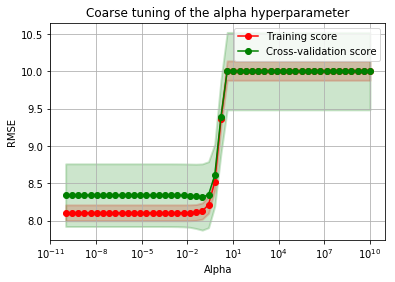

In [55]:
alpha_range = np.logspace(-10, 10, 50)

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['imdbGrade'], param_name="lasso__alpha",
                                                       param_range=alpha_range, cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range,
                      'log', 'Coarse tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

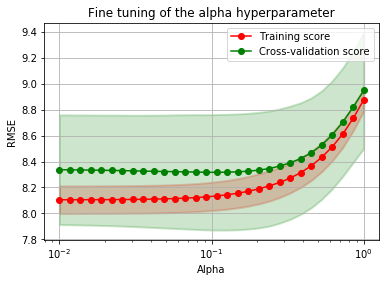

In [56]:
alpha_range_fine = np.logspace(-2, 0, 30)

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['imdbGrade'], param_name="lasso__alpha",
                                                       param_range=alpha_range_fine, cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range_fine,
                      'log', 'Fine tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

In [57]:
optimal_alpha_l = alpha_range_fine[cv_scores_val_l.mean(axis=1).argmin()]
lasso_pipeline.set_params(lasso__alpha = optimal_alpha_l)

lasso_pipeline.fit(X_train,y_train['imdbGrade'])
lasso_predict = lasso_pipeline.predict(X_test)

lasso_regr_imdb = np.abs(lasso_pipeline.named_steps['lasso'].coef_.copy())
print(lasso_regr_imdb)

[0.20121847 1.22812353 1.87488411 0.87825575 0.52210277 0.49098157
 0.68070449 0.         1.22257149 0.66226176 1.81855592 0.
 0.9335876  2.47391598 0.         0.35198269 0.0852707  1.30889025
 0.30087534 0.26678189 0.04981992 0.         0.29914047 0.1138216
 0.0978249  0.58351524 0.         0.18624932 0.94331466 0.63597196
 0.         0.         0.         0.         0.         1.60129492
 0.00453865]


In [58]:
X_train.columns

Index(['Budget', 'BoxOffice_actors', 'BoxOffice_directors',
       'BoxOffice_writers', 'foreign', 'usa', 'action', 'adventure',
       'animation', 'biography', 'comedy', 'crime', 'documentary', 'drama',
       'family', 'fantasy', 'history', 'horror', 'music', 'musical', 'mystery',
       'news', 'romance', 'sci-fi', 'sport', 'thriller', 'war', 'western',
       'english', 'other', 'spanish', 'g', 'nc-17', 'pg', 'pg-13', 'r',
       'unrated'],
      dtype='object')

In [59]:
feature_zero_IMdB = X_train.columns[np.where(lasso_regr_imdb == 0)[0]]
set_non_zero_features_IMdB = set(X_train.columns[np.where(lasso_regr_imdb != 0)[0]])

# The feature list is ordeed by importance then we keep only the 5 most important features
feature_IMdB = X_train.columns[np.argsort(lasso_regr_imdb)][::-1][:5]

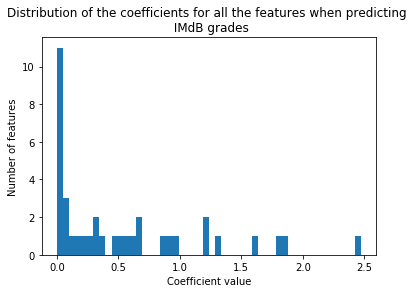

In [60]:
plt.figure(1)
plt.hist(np.abs(lasso_regr_imdb),bins=50)
plt.title('Distribution of the coefficients for all the features when predicting \n IMdB grades')
plt.xlabel('Coefficient value')
plt.ylabel('Number of features')
plt.show()

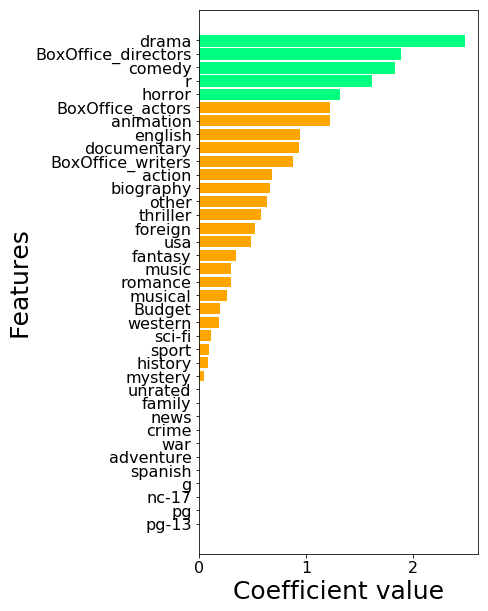

In [68]:
lasso_imdb_df = pd.DataFrame([lasso_regr_imdb, X_train.columns], index=['coef', 'features']).transpose().sort_values(by=['coef'])

plt.figure(figsize = (5,10))

plt.rcParams.update({'font.size': 16})

barlist = plt.barh(lasso_imdb_df.features, lasso_imdb_df.coef, 
            color = 'orange')

barlist[-1].set_color('springgreen')
barlist[-2].set_color('springgreen')
barlist[-3].set_color('springgreen')
barlist[-4].set_color('springgreen')
barlist[-5].set_color('springgreen')

plt.xlabel('Coefficient value', size=25)
plt.ylabel('Features' , size=25)
plt.savefig('Figures/IMDB_feat.png', bbox_inches="tight")
plt.show()

## 3.2 Rotten Tomatoes grade as target

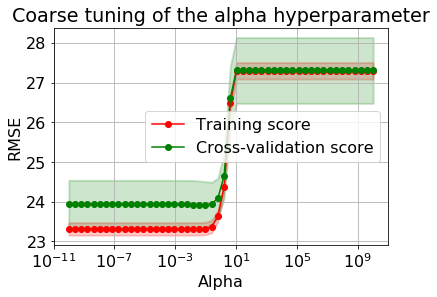

In [69]:
alpha_range = np.logspace(-10, 10, 50)

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['tomatoGrade'],
                                                       param_name="lasso__alpha",param_range=alpha_range,
                                                       cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range,
                      'log', 'Coarse tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

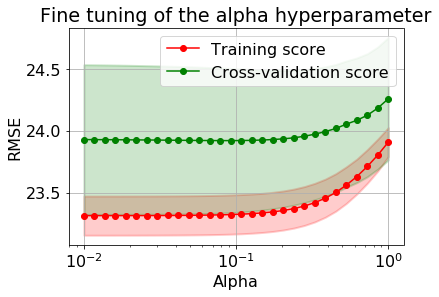

In [70]:
alpha_range_fine = np.logspace(-2, 0, 30)

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['tomatoGrade'],
                                                       param_name="lasso__alpha",param_range=alpha_range_fine,
                                                       cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range_fine,
                      'log', 'Fine tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

In [71]:
optimal_alpha_l = alpha_range_fine[cv_scores_val_l.mean(axis=1).argmin()]
lasso_pipeline.set_params(lasso__alpha = optimal_alpha_l)

lasso_pipeline.fit(X_train,y_train['tomatoGrade'])
lasso_predict = lasso_pipeline.predict(X_test)

lasso_regr_RT = np.abs(lasso_pipeline.named_steps['lasso'].coef_.copy())
print(lasso_regr_RT)

[2.85214739 2.93472142 4.29342091 3.64431069 0.80624448 2.6284731
 2.32934488 1.43385631 2.91717505 1.5628415  2.15428942 0.50322484
 3.79547206 6.69963475 1.27582812 1.07230769 0.61417825 1.70799253
 0.36457026 1.4986922  0.557637   0.02080079 1.9285372  1.05649605
 0.21911412 1.8626413  0.78621324 0.57618236 2.0294815  1.96392925
 0.45075598 0.52380135 0.33710789 0.         0.87606132 4.30943717
 0.        ]


In [72]:
feature_zero_RT = X_train.columns[np.where(lasso_regr_RT == 0)[0]]
set_non_zero_features_RT = set(X_train.columns[np.where(lasso_regr_RT != 0)[0]])

# The feature list is ordeed by importance then we keep only the 5 most important features
feature_RT = X_train.columns[np.argsort(lasso_regr_RT)][::-1][:5]

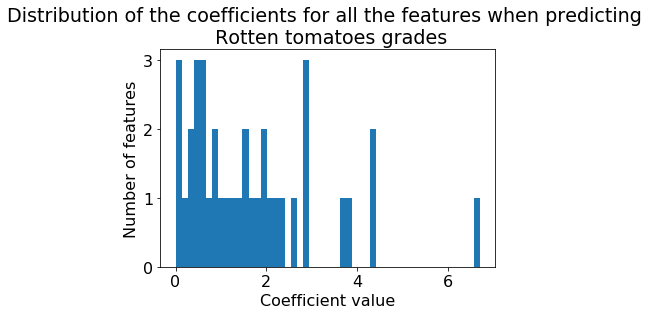

In [73]:
plt.figure(2)
plt.hist(np.abs(lasso_regr_RT),bins=50)
plt.title('Distribution of the coefficients for all the features when predicting \n Rotten tomatoes grades')
plt.xlabel('Coefficient value')
plt.ylabel('Number of features')
plt.show()

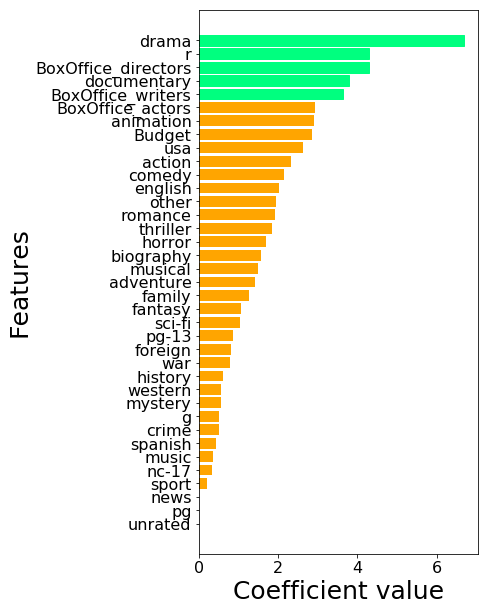

In [74]:
lasso_RT_df = pd.DataFrame([lasso_regr_RT, X_train.columns], index=['coef', 'features']).transpose().sort_values(by=['coef'])

plt.figure(figsize = (5,10))
barlist = plt.barh(lasso_RT_df.features, lasso_RT_df.coef, 
            color = 'orange')

barlist[-1].set_color('springgreen')
barlist[-2].set_color('springgreen')
barlist[-3].set_color('springgreen')
barlist[-4].set_color('springgreen')
barlist[-5].set_color('springgreen')

plt.xlabel('Coefficient value', size=25)
plt.ylabel('Features' , size=25)
plt.savefig('Figures/RT_feat.png', bbox_inches="tight")
plt.show()

## 3.3 Metacritic grade as target

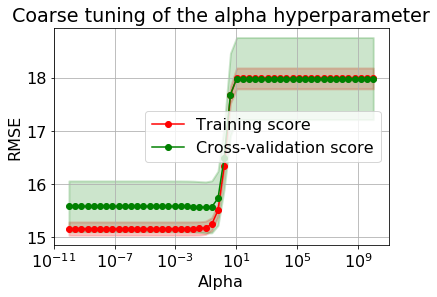

In [75]:
alpha_range = np.logspace(-10, 10, 50)

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['metacriticGrade'],
                                                       param_name="lasso__alpha",param_range=alpha_range,
                                                       cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range,
                      'log', 'Coarse tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

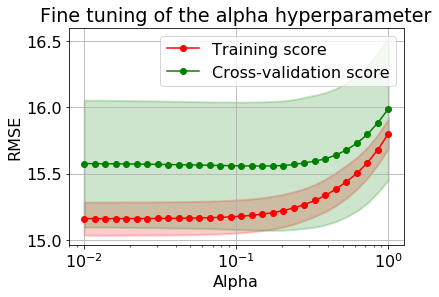

In [76]:
alpha_range_fine = np.logspace(-2, 0, 30) 

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['metacriticGrade'],
                                                       param_name="lasso__alpha",param_range=alpha_range_fine,
                                                       cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range_fine,
                      'log', 'Fine tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

In [77]:
optimal_alpha_l = alpha_range_fine[cv_scores_val_l.mean(axis=1).argmin()]
lasso_pipeline.set_params(lasso__alpha = optimal_alpha_l)

lasso_pipeline.fit(X_train,y_train['tomatoGrade'])
lasso_predict = lasso_pipeline.predict(X_test)

lasso_regr_MC = np.abs(lasso_pipeline.named_steps['lasso'].coef_.copy())
print(lasso_regr_MC)

[2.58316544 2.79303923 4.21344723 3.5782196  0.73528879 2.61424022
 2.29183096 1.31921628 2.86589147 1.54737747 2.0133262  0.42490484
 3.72896926 6.65585265 1.06278743 0.96993635 0.52015793 1.64950572
 0.33297223 1.44877045 0.47998978 0.         1.86504035 0.99441554
 0.17952069 1.79399587 0.68281595 0.52093758 1.97143127 1.89877774
 0.3810993  0.49067869 0.27300039 0.         1.12275275 3.96789177
 0.        ]


In [78]:
feature_zero_MC = X_train.columns[np.where(lasso_regr_MC == 0)[0]]
set_non_zero_features_MC = set(X_train.columns[np.where(lasso_regr_MC != 0)[0]])

# The feature list is ordeed by importance then we keep only the 5 most important features
feature_MC = X_train.columns[np.argsort(lasso_regr_MC)][::-1][:5]

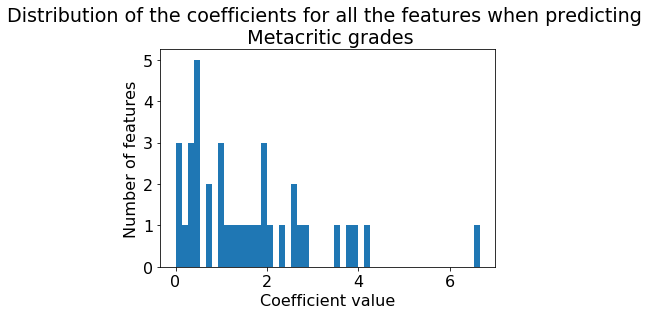

In [79]:
plt.hist(np.abs(lasso_regr_MC),bins=50)
plt.title('Distribution of the coefficients for all the features when predicting \n Metacritic grades')
plt.xlabel('Coefficient value')
plt.ylabel('Number of features')
plt.show()

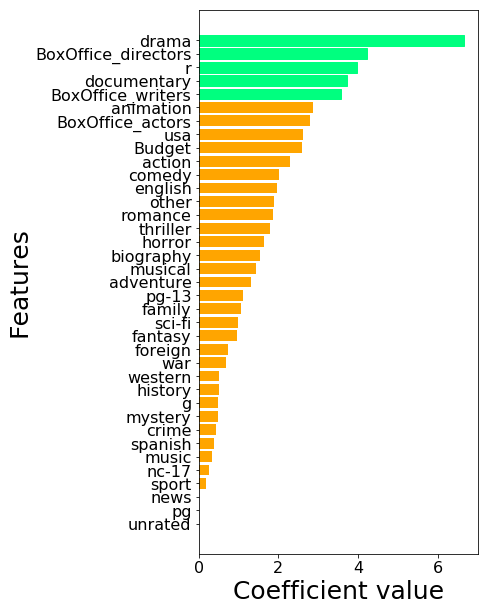

In [80]:
lasso_MC_df = pd.DataFrame([lasso_regr_MC, X_train.columns], index=['coef', 'features']).transpose().sort_values(by=['coef'])

plt.figure(figsize = (5,10))
barlist = plt.barh(lasso_MC_df.features, lasso_MC_df.coef, 
            color = 'orange')

barlist[-1].set_color('springgreen')
barlist[-2].set_color('springgreen')
barlist[-3].set_color('springgreen')
barlist[-4].set_color('springgreen')
barlist[-5].set_color('springgreen')

plt.xlabel('Coefficient value', size=25)
plt.ylabel('Features' , size=25)
plt.savefig('Figures/MC_feat.png', bbox_inches="tight")
plt.show()

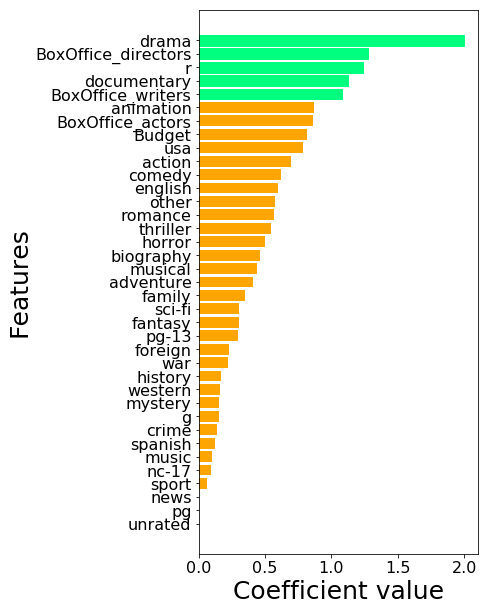

In [81]:
pre_crit_MC = lasso_MC_df.sort_values(by=['features'])
pre_crit_MC['coef'] = pre_crit_MC["coef"] / pre_crit_MC["coef"].max()
pre_crit_RT = lasso_RT_df.sort_values(by=['features'])
pre_crit_RT['coef'] = pre_crit_RT["coef"] / pre_crit_RT["coef"].max()

crit = pd.DataFrame()
crit['features'] = pre_crit_MC.features
crit['coef'] = pre_crit_MC.coef + pre_crit_RT.coef
crit = crit.sort_values(by=['coef'])
crit.reset_index(inplace = True)

plt.figure(figsize = (5,10))
barlist = plt.barh(crit.features, crit.coef, 
            color = 'orange')

barlist[-1].set_color('springgreen')
barlist[-2].set_color('springgreen')
barlist[-3].set_color('springgreen')
barlist[-4].set_color('springgreen')
barlist[-5].set_color('springgreen')

plt.xlabel('Coefficient value', size=25)
plt.ylabel('Features' , size=25)
plt.savefig('Figures/crit_feat.png', bbox_inches="tight")
plt.show()

## 3.4  Box office as target

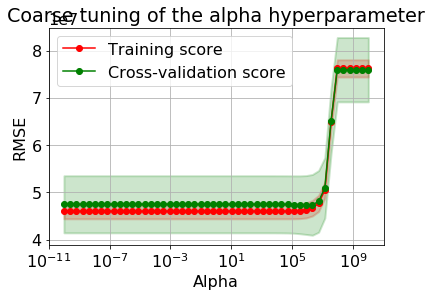

In [82]:
alpha_range = np.logspace(-10, 10, 50)

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['BoxOffice'],
                                                       param_name="lasso__alpha",param_range=alpha_range,
                                                       cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range,
                      'log', 'Coarse tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

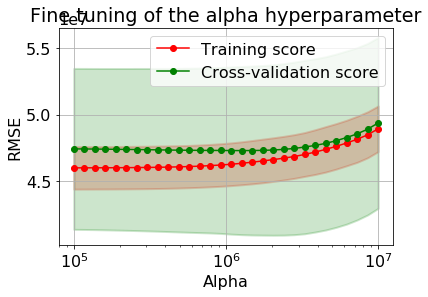

In [83]:
alpha_range_fine = np.logspace(5, 7, 30) 

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['BoxOffice'],
                                                       param_name="lasso__alpha",param_range=alpha_range_fine,
                                                       cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range_fine,
                      'log', 'Fine tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

In [84]:
optimal_alpha_l = alpha_range_fine[cv_scores_val_l.mean(axis=1).argmin()]
lasso_pipeline.set_params(lasso__alpha = optimal_alpha_l)

lasso_pipeline.fit(X_train,y_train['BoxOffice'])
lasso_predict = lasso_pipeline.predict(X_test)

lasso_regr_BO = np.abs(lasso_pipeline.named_steps['lasso'].coef_.copy())
print(lasso_regr_BO)

[22582699.59544871 17492763.52523933 14039251.9875107  17236269.0969669
  2043184.50784759   983009.92094312   339681.04979371        0.
  1387246.27646871        0.           262996.02012373  2095543.41786444
        0.          1047669.17512202   628267.42669302   732432.2640471
   454865.34066128  1238902.29033156   833783.23363126   369295.75230534
        0.                0.                0.                0.
        0.           483460.60965932   670132.07363192  2982537.6761512
   665703.94023063  1091381.33933373   739564.14987432  1103469.96967151
        0.          2380110.70548703        0.          1612940.01551492
        0.        ]


In [85]:
feature_zero_BO = X_train.columns[np.where(lasso_regr_BO == 0)[0]]
set_non_zero_features_BO = set(X_train.columns[np.where(lasso_regr_BO != 0)[0]])

# The feature list is ordeed by importance then we keep only the 5 most important features
feature_BO = X_train.columns[np.argsort(lasso_regr_BO)][::-1][:5]

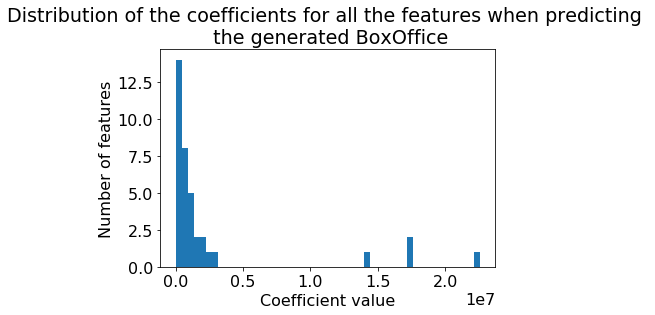

In [86]:
plt.figure(4)
plt.hist(np.abs(lasso_regr_BO),bins=50)
plt.title('Distribution of the coefficients for all the features when predicting \n the generated BoxOffice')
plt.xlabel('Coefficient value')
plt.ylabel('Number of features')
plt.show()

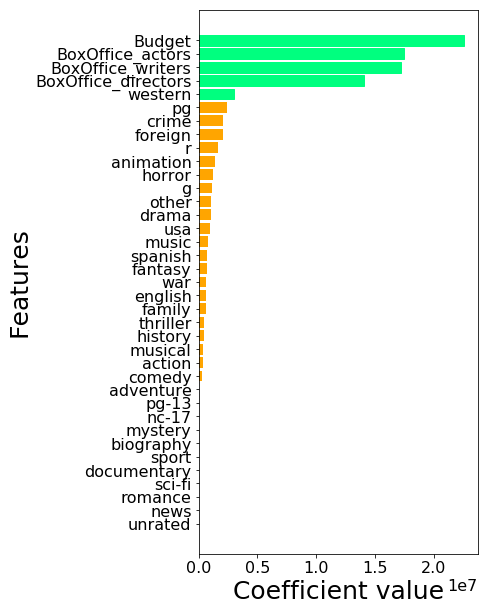

In [87]:
lasso_BO_df = pd.DataFrame([lasso_regr_BO, X_train.columns], index=['coef', 'features']).transpose().sort_values(by=['coef'])

plt.figure(figsize = (5,10))
barlist = plt.barh(lasso_BO_df.features, lasso_BO_df.coef, 
            color = 'orange')

barlist[-1].set_color('springgreen')
barlist[-2].set_color('springgreen')
barlist[-3].set_color('springgreen')
barlist[-4].set_color('springgreen')
barlist[-5].set_color('springgreen')

plt.xlabel('Coefficient value', size=25)
plt.ylabel('Features' , size=25)
plt.savefig('Figures/BO_feat.png', bbox_inches="tight")
plt.show()

## 3.5 Nominations as target

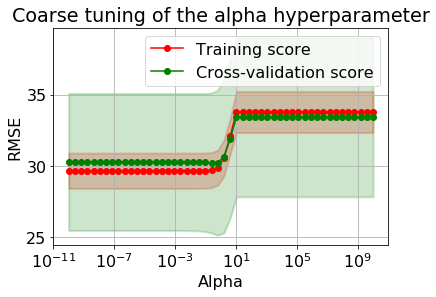

In [88]:
alpha_range = np.logspace(-10, 10, 50)

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['Nominations'],
                                                       param_name="lasso__alpha",param_range=alpha_range,
                                                       cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range,
                      'log', 'Coarse tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

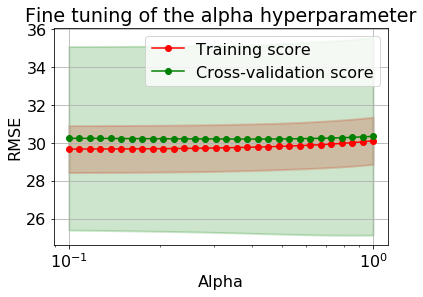

In [89]:
alpha_range_fine = np.logspace(-1, 0, 30) 

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['Nominations'],
                                                       param_name="lasso__alpha",param_range=alpha_range_fine,
                                                       cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range_fine,
                      'log', 'Fine tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

In [90]:
optimal_alpha_l = alpha_range_fine[cv_scores_val_l.mean(axis=1).argmin()]
lasso_pipeline.set_params(lasso__alpha = optimal_alpha_l)

lasso_pipeline.fit(X_train,y_train['Nominations'])
lasso_predict = lasso_pipeline.predict(X_test)

lasso_regr_Nom = np.abs(lasso_pipeline.named_steps['lasso'].coef_.copy())
print(lasso_regr_Nom)

[0.84445865 4.28175715 6.02347048 2.02398558 2.13326362 0.
 4.09608364 2.42845997 0.96696528 2.11563432 4.12584578 1.12252612
 0.32757071 6.12897912 0.26199975 0.         0.09882929 1.4767262
 0.04259716 1.5568799  0.         0.         0.86556208 1.18882351
 1.30516063 3.50564111 0.63448701 0.8539381  1.35361264 1.21246918
 0.81082271 0.         0.69993998 0.98242268 0.         3.88630928
 0.22954302]


In [91]:
feature_zero_Nom = X_train.columns[np.where(lasso_regr_Nom == 0)[0]]
set_non_zero_features_Nom = set(X_train.columns[np.where(lasso_regr_Nom != 0)[0]])

# The feature list is ordeed by importance then we keep only the 5 most important features
feature_Nom = X_train.columns[np.argsort(lasso_regr_Nom)][::-1][:5]

In [92]:
feature_Nom

Index(['drama', 'BoxOffice_directors', 'BoxOffice_actors', 'comedy', 'action'], dtype='object')

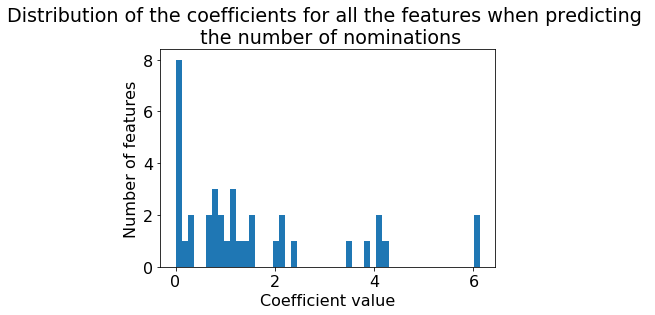

In [93]:
plt.hist(np.abs(lasso_regr_Nom),bins=50)
plt.title('Distribution of the coefficients for all the features when predicting \n the number of nominations')
plt.xlabel('Coefficient value')
plt.ylabel('Number of features')
plt.show()

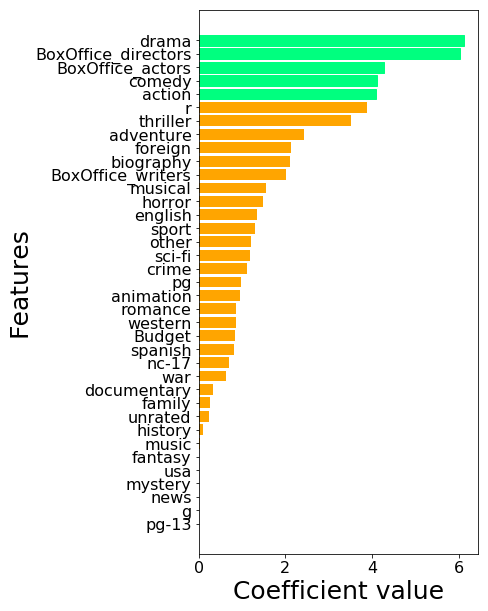

In [94]:
lasso_Nom_df = pd.DataFrame([lasso_regr_Nom, X_train.columns], index=['coef', 'features']).transpose().sort_values(by=['coef'])

plt.figure(figsize = (5,10))
barlist = plt.barh(lasso_Nom_df.features, lasso_Nom_df.coef, 
            color = 'orange')

barlist[-1].set_color('springgreen')
barlist[-2].set_color('springgreen')
barlist[-3].set_color('springgreen')
barlist[-4].set_color('springgreen')
barlist[-5].set_color('springgreen')

plt.xlabel('Coefficient value', size=25)
plt.ylabel('Features' , size=25)
plt.savefig('Figures/Nom_feat.png', bbox_inches="tight")
plt.show()

## 3.6 Wins as target

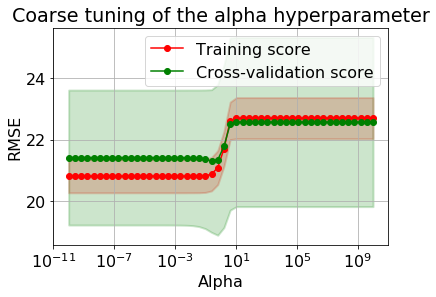

In [95]:
alpha_range = np.logspace(-10, 10, 50)

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['Wins'],
                                                       param_name="lasso__alpha",param_range=alpha_range,
                                                       cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range,
                      'log', 'Coarse tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

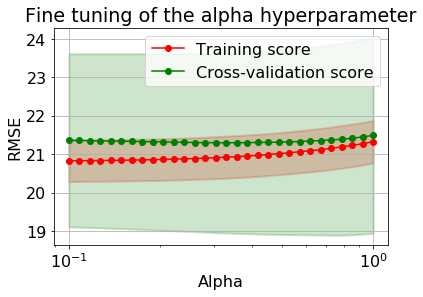

In [96]:
alpha_range_fine = np.logspace(-1, 0, 30) 

train_scores_val_l, cv_scores_val_l = validation_curve(lasso_pipeline, X_train, y_train['Wins'],
                                                       param_name="lasso__alpha",param_range=alpha_range_fine,
                                                       cv=5, scoring=MSE,n_jobs = -1)
plot_validation_curve(np.sqrt(train_scores_val_l), np.sqrt(cv_scores_val_l), alpha_range_fine,
                      'log', 'Fine tuning of the alpha hyperparameter', 'RMSE', 'Alpha')

In [97]:
optimal_alpha_l = alpha_range_fine[cv_scores_val_l.mean(axis=1).argmin()]
lasso_pipeline.set_params(lasso__alpha = optimal_alpha_l)

lasso_pipeline.fit(X_train,y_train['Wins'])
lasso_predict = lasso_pipeline.predict(X_test)

lasso_regr_Wins = np.abs(lasso_pipeline.named_steps['lasso'].coef_.copy())
print(lasso_regr_Wins)

[0.         1.41677494 3.3979195  0.78245083 1.5268877  0.
 2.19615547 0.60111988 0.63453807 0.63043482 2.47795942 0.99678457
 0.         3.17762884 0.         0.         0.         1.10502046
 0.         0.46841434 0.43843616 0.         0.57448763 0.11188977
 0.57813261 1.3656518  0.01924841 0.29660315 1.93594717 0.87099507
 0.         0.         0.23343409 0.42963416 0.         1.73594831
 0.2409524 ]


In [98]:
feature_zero_Wins = X_train.columns[np.where(lasso_regr_Wins == 0)[0]]
set_non_zero_features_Wins = set(X_train.columns[np.where(lasso_regr_Wins != 0)[0]])

# The feature list is ordeed by importance then we keep only the 5 most important features
feature_Wins = X_train.columns[np.argsort(lasso_regr_Wins)][::-1][:5]

In [99]:
feature_Wins

Index(['BoxOffice_directors', 'drama', 'comedy', 'action', 'english'], dtype='object')

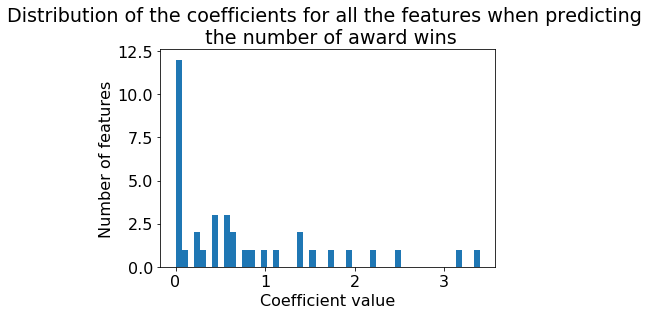

In [100]:
plt.hist(np.abs(lasso_regr_Wins),bins=50)
plt.title('Distribution of the coefficients for all the features when predicting \n the number of award wins')
plt.xlabel('Coefficient value')
plt.ylabel('Number of features')
plt.show()

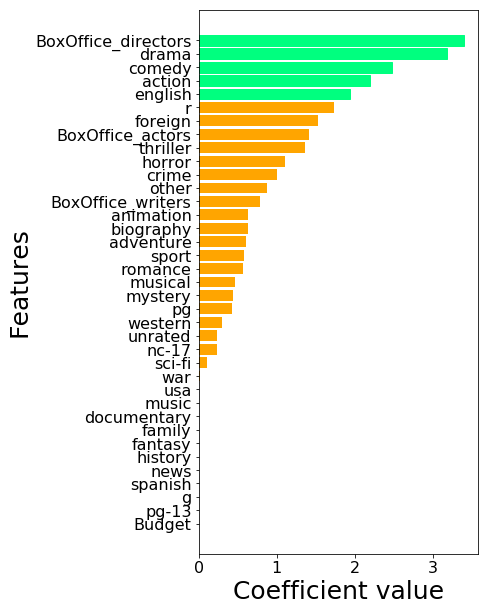

In [101]:
lasso_Wins_df = pd.DataFrame([lasso_regr_Wins, X_train.columns], index=['coef', 'features']).transpose().sort_values(by=['coef'])

plt.figure(figsize = (5,10))
barlist = plt.barh(lasso_Wins_df.features, lasso_Wins_df.coef, 
            color = 'orange')

barlist[-1].set_color('springgreen')
barlist[-2].set_color('springgreen')
barlist[-3].set_color('springgreen')
barlist[-4].set_color('springgreen')
barlist[-5].set_color('springgreen')

plt.xlabel('Coefficient value', size=25)
plt.ylabel('Features' , size=25)
plt.savefig('Figures/Wins_feat.png', bbox_inches="tight")
plt.show()

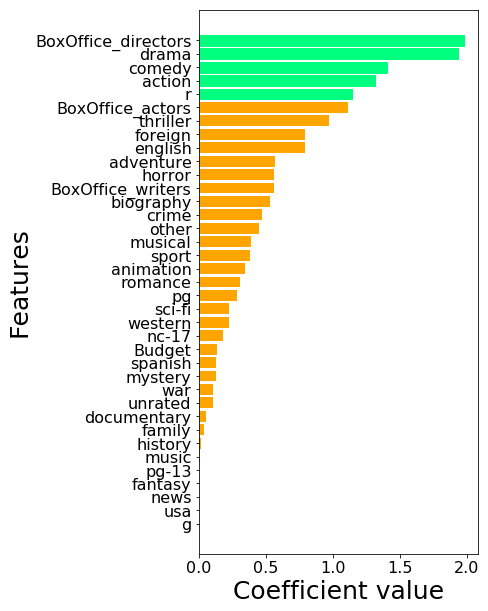

In [102]:
pre_aw_Nom = lasso_Nom_df.sort_values(by=['features'])
pre_aw_Nom['coef'] = pre_aw_Nom["coef"] / pre_aw_Nom["coef"].max()
pre_aw_Win = lasso_Wins_df.sort_values(by=['features'])
pre_aw_Win['coef'] = pre_aw_Win["coef"] / pre_aw_Win["coef"].max()

awards = pd.DataFrame()
awards['features'] = pre_aw_Nom.features
awards['coef'] = pre_aw_Nom.coef + pre_aw_Win.coef
awards = awards.sort_values(by=['coef'])
awards.reset_index(inplace = True)

plt.figure(figsize = (5,10))
barlist = plt.barh(awards.features, awards.coef, 
            color = 'orange')

barlist[-1].set_color('springgreen')
barlist[-2].set_color('springgreen')
barlist[-3].set_color('springgreen')
barlist[-4].set_color('springgreen')
barlist[-5].set_color('springgreen')

plt.xlabel('Coefficient value', size=25)
plt.ylabel('Features' , size=25)
plt.savefig('Figures/awards_feat.png', bbox_inches="tight")
plt.show()

plt.rcParams.update({'font.size': 10})

## 3.7 Importance of features

In [103]:
# The list of features important to determine all the different target
set(feature_MC) & set(feature_RT)&set(feature_Nom) & set(feature_Wins)&set(feature_BO)&set(feature_IMdB)

{'BoxOffice_directors'}

In [104]:
# Extreme list of "important" features
set_non_zero_features_BO&set_non_zero_features_IMdB&set_non_zero_features_MC&\
set_non_zero_features_RT&set_non_zero_features_Nom

{'BoxOffice_actors',
 'BoxOffice_directors',
 'BoxOffice_writers',
 'Budget',
 'action',
 'animation',
 'comedy',
 'drama',
 'english',
 'foreign',
 'history',
 'horror',
 'music',
 'musical',
 'other',
 'r',
 'thriller',
 'western'}

In [105]:
# List of "important" features for the imdb grades target
feature_IMdB

Index(['drama', 'BoxOffice_directors', 'comedy', 'r', 'horror'], dtype='object')

In [106]:
# Conservative list of "important" features for the critics target
feature_MC & feature_RT

Index(['drama', 'BoxOffice_directors', 'r', 'documentary',
       'BoxOffice_writers'],
      dtype='object')

In [107]:
feature_BO

Index(['Budget', 'BoxOffice_actors', 'BoxOffice_writers',
       'BoxOffice_directors', 'western'],
      dtype='object')

In [108]:
# Conservative list of "important" features for the academic target
feature_Nom & feature_Wins

Index(['drama', 'BoxOffice_directors', 'comedy', 'action'], dtype='object')

In [109]:
#List of features to keep across all metrics
a = set(['drama', 'BoxOffice_directors', 'comedy', 'r', 'horror'])
b = set(['drama', 'BoxOffice_directors', 'r', 'documentary',
       'BoxOffice_writers'])
c = set(['Budget', 'BoxOffice_actors', 'BoxOffice_writers',
       'BoxOffice_directors', 'western'])
d = set(['drama', 'BoxOffice_directors', 'comedy', 'action'])

a|b|c|d


{'BoxOffice_actors',
 'BoxOffice_directors',
 'BoxOffice_writers',
 'Budget',
 'action',
 'comedy',
 'documentary',
 'drama',
 'horror',
 'r',
 'western'}

# 4. Graph creation

After data cleaning, we proceed to the creation of the graph by computing its adjacency matrix. We wish to create an adjacency matrix containing all features. We will hence compute several adjacency matrices that we will then add (using weighting factors). Such matrices are:

- Crew (actors, writers and directors): how many crew members the movies have in common
- Budget: the similarity between movies will be based on how close the budgets are (in a log scale)
- Genre: how many genres two movies have in common
- Production: is it the same production company?
- Plot: how many common words two films have in common
- Rated category: binary score = same category or different

In [110]:
final_df = pd.read_pickle("Data/final_df.pkl")
final_df = final_df.reset_index(drop=True)
final_df = final_df.drop(columns=['index'])
final_df.head()

,Actors,BoxOffice,Country,Director,Genre,Language,metacriticGrade,Plot,Production,Rated,...,Writer,imdbGrade,imdbVotes,tomatoGrade,Wins,Nominations,Budget,BoxOffice_actors,BoxOffice_directors,BoxOffice_writers
0,"{Sam Worthington, Zoe Saldana, Sigourney Weave...",749700000,"{Foreign, USA}",{James Cameron},"{Sci-Fi, Adventure, Action, Fantasy}","{English, Spanish}",83,"{mission, moon, marine, home, orders, world}",{20th Century Fox},{PG-13},...,{James Cameron},78,1013715.0,82,88,128,237000000.0,4374612546,947816802,1173684544
1,"{Geoffrey Rush, Johnny Depp, Keira Knightley, ...",309404152,{USA},{Gore Verbinski},"{Adventure, Action, Fantasy}",{English},50,"{treachery, map, betrayal, edge, battle, allia...",{Buena Vista},{PG-13},...,"{Ted Elliott, Jay Wolpert, Stuart Beattie, Ter...",71,542125.0,44,20,46,300000000.0,5814521117,1329316576,6439780219
2,"{Ralph Fiennes, Léa Seydoux, Christoph Waltz, ...",208777731,"{Foreign, USA}",{Sam Mendes},"{Adventure, Thriller, Action}","{English, Other, Spanish}",60,"{events, involvement, organization, message, l...",{Sony},{PG-13},...,"{Ian Fleming, Neal Purvis, John Logan, Robert ...",68,343533.0,64,8,32,245000000.0,3239589157,706988158,4338225868
3,"{Tom Hardy, Gary Oldman, Christian Bale, Josep...",448130642,"{Foreign, USA}",{Christopher Nolan},"{Thriller, Action}","{English, Other}",78,"{edge, guerrilla, annihilation, reign, anarchy...",{Warner Bros},{PG-13},...,"{Bob Kane, David S. Goyer, Christopher Nolan, ...",84,1344474.0,87,38,103,250000000.0,5076524906,1781097215,6820715653
4,"{Samantha Morton, Willem Dafoe, Lynn Collins, ...",73058679,{USA},{Andrew Stanton},"{Sci-Fi, Adventure, Action}",{English},51,"{princess, prisoner, barbarians, planet, creat...",{Disney},{PG-13},...,"{Andrew Stanton, Michael Chabon, Mark Andrews,...",66,234717.0,51,2,8,260000000.0,1356678203,677337921,2082778011


## 4.1 Division into categories for budget + creation of Awards feature

In [111]:
# No budget: less than 100 000 
# Independent: 100 000 to 10 million 
# Low: 10 to 40 million 
# Medium: 41 to 100 million 
# High: 101 million and up 

def transform_budget(budget):
    if budget < 100000:
        budget_cat = 1
    elif budget >= 100000 and budget < 10000000:
        budget_cat = 2
    elif budget >= 10000000 and budget < 40000000:
        budget_cat = 3
    elif budget >= 40000000 and budget < 100000000:
        budget_cat = 4
    elif budget >= 100000000:
        budget_cat = 5
        
    return budget_cat

final_df['TrueBudget'] = final_df['Budget'].copy()
final_df.Budget = final_df.Budget.apply(lambda x: transform_budget(x))

final_df['Awards'] = final_df['Wins'] + final_df['Nominations']

## 4.2 Adjacencies

In [112]:
# 1. Cast and crew
weights_dir = np.zeros((len(final_df), len(final_df)))
weights_actors = np.zeros((len(final_df), len(final_df)))
weights_writer = np.zeros((len(final_df), len(final_df)))

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_dir[i][j] = weights_dir[i][j] + len(final_df['Director'][i] & final_df['Director'][j])
weights_dir = weights_dir + weights_dir.T
weights_dir = weights_dir/np.max(weights_dir)

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_actors[i][j] = weights_actors[i][j] + len(final_df['Actors'][i] & final_df['Actors'][j])
weights_actors = weights_actors + weights_actors.T
weights_actors = weights_actors/np.max(weights_actors)

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_writer[i][j] = weights_writer[i][j] + len(final_df['Writer'][i] & final_df['Writer'][j])
weights_writer = weights_writer + weights_writer.T
weights_writer = weights_writer/np.max(weights_writer)

# 2. Budget
weights_budget = np.zeros((len(final_df), len(final_df)))
for i in range(len(final_df)):
    for j in range(i+1, len(final_df)):
        diff = np.abs(final_df['Budget'][i] - final_df['Budget'][j])
        if diff == 0:
            weights_budget[i][j] = 1
        else: 
            weights_budget[i][j] = 0
weights_budget = weights_budget + weights_budget.T
weights_budget = weights_budget/np.max(weights_budget)

# 3. Genre
weights_genre = np.zeros((len(final_df), len(final_df)))
for i in range(len(final_df)):
    for j in range(i+1, len(final_df)):
        if len(final_df['Genre'][i] & final_df['Genre'][j]) > 1:
            weights_genre[i][j] = 1
        elif len(final_df['Genre'][i] & final_df['Genre'][j]) == 1:
            weights_genre[i][j] = 0.5
        else:
            weights_genre[i][j] = 0
weights_genre = weights_genre + weights_genre.T
weights_genre = weights_genre/np.max(weights_genre)

# 4. Plot
weights_plot = np.zeros((len(final_df), len(final_df)))
for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_plot[i][j] = len(final_df['Plot'][i] & final_df['Plot'][j])
weights_plot = weights_plot + weights_plot.T
weights_plot = weights_plot/np.max(weights_plot)

# 5. Production
weights_prod = np.zeros((len(final_df), len(final_df)))
for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_prod[i][j] = len(final_df['Production'][i] & final_df['Production'][j])
weights_prod = weights_prod + weights_prod.T
weights_prod = weights_prod/np.max(weights_prod)

# Save
np.save('Data/weights_dir.npy', weights_dir)
np.save('Data/weights_act.npy', weights_actors)
np.save('Data/weights_wri.npy', weights_writer)
np.save('Data/weights_budget.npy', weights_budget)
np.save('Data/weights_genre.npy', weights_genre)
np.save('Data/weights_prod.npy', weights_prod)
np.save('Data/weights_plot.npy', weights_plot)

### Load

In [113]:
weights_actors = np.load('Data/weights_act.npy')
weights_dir = np.load('Data/weights_dir.npy')
weights_writer = np.load('Data/weights_wri.npy')
weights_budget = np.load('Data/weights_budget.npy')
weights_genre = np.load('Data/weights_genre.npy')
weights_prod = np.load('Data/weights_prod.npy')
weights_plot = np.load('Data/weights_plot.npy')

## 4.3 Total adjacency matrix

Now, we need to add all weight matrices and to divide the total adjacency matrix by the number of sub-adjacencies (7).

In [114]:
adjacency = (weights_actors + weights_dir + weights_writer + 
                   weights_budget + weights_genre + weights_prod + weights_plot) / 7
np.save('Data/adjacency.npy', adjacency)

print('Sparsity of our network:', np.count_nonzero(adjacency==0)*100/(len(adjacency)**2), '%')

Sparsity of our network: 26.876002103360904 %


In order to sparsify our network, we kept only the 250 strongest neighbors.

In [115]:
sparse_adj = np.zeros((len(adjacency), len(adjacency)))
for i in range(len(adjacency)):
    for j in range(i+1, len(adjacency)):
        row = adjacency[i,:].copy()
        thresh = -np.sort(-row)[199]
        row[row < thresh] = 0
        sparse_adj[i,:] = row
        
sparse_adj = sparse_adj + sparse_adj.T
np.save('Data/sparse_adj.npy', sparse_adj)
print('Sparsity of our network:', np.count_nonzero(sparse_adj==0)*100/(len(sparse_adj)**2), '%')

Sparsity of our network: 79.54600803770145 %


In [116]:
sparse_adj = np.load('Data/sparse_adj.npy')
adjacency = np.load('Data/adjacency.npy')

# 5. Analysis

## 5.1 Label creation

In [117]:
label_boxoffice = final_df.BoxOffice.values.copy()
label_imdb = final_df.imdbGrade.values.copy()
label_tomato = final_df.tomatoGrade.values.copy()
label_metacritic = final_df.metacriticGrade.values.copy()
label_wins = final_df.Wins.values.copy()
label_noms = final_df.Nominations.values.copy()

label_critics = (label_tomato + label_metacritic)/2
label_critics[label_critics < 60] = 0
label_critics[label_critics >= 60] = 1

third_quart_imdb = final_df.imdbGrade.quantile(0.75)
label_imdb[label_imdb < 68] = 0
label_imdb[label_imdb >= 68] = 1

third_quart_box = final_df.BoxOffice.quantile(0.75)
label_boxoffice[label_boxoffice > third_quart_box] = third_quart_box
label_boxoffice = label_boxoffice / third_quart_box

third_quart_awards = final_df.Awards.quantile(0.75)
label_awards = final_df.Awards.values.copy()
label_awards[label_awards > third_quart_awards] = third_quart_awards
label_awards = label_awards / third_quart_awards

## 5.2 Graph

In [118]:
G = nx.from_numpy_matrix(sparse_adj)
print('Connectedness of our graph:', nx.is_connected(G))

Connectedness of our graph: True


Now that we know our graph is connected, we can use the whole adjacency matrix for the analysis.

In [119]:
degree_weighted = sparse_adj.sum(1)
D = np.diag(degree_weighted)

D_norm = np.diag(np.sqrt(1./degree_weighted))
D_norm[D_norm == np.inf] = 0

laplacian = sprs.csgraph.laplacian(sparse_adj, normed=False)

e, U = sp.linalg.eigh(laplacian)
coords = U[:,[2,4]]  # Laplacian eigenmaps

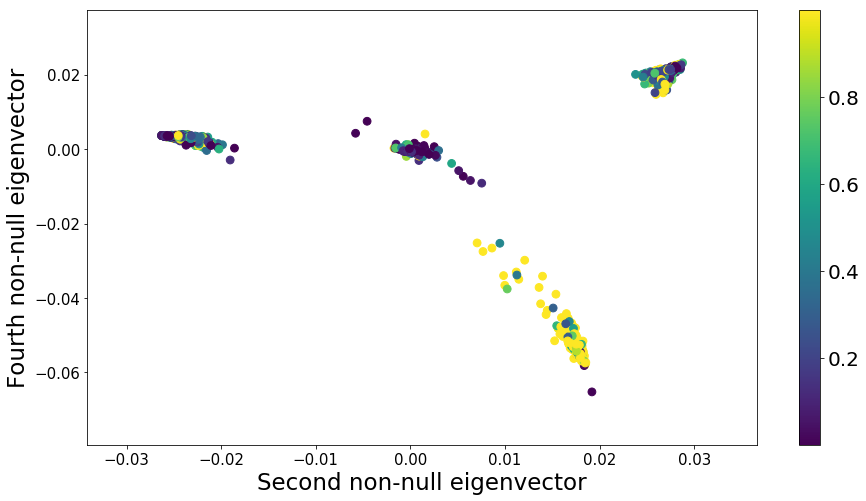

In [120]:
plt.figure(figsize = (15,8))
nodes = nx.draw_networkx_nodes(G, coords, node_size=60, node_color=label_boxoffice)
plt.xlabel("Second non-null eigenvector", size=23)
plt.ylabel("Fourth non-null eigenvector", size=23)
cbar = plt.colorbar(nodes)
cbar.ax.tick_params(labelsize=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.savefig("Figures/graph_boxoffice.pdf", bbox_inches="tight")
plt.show()

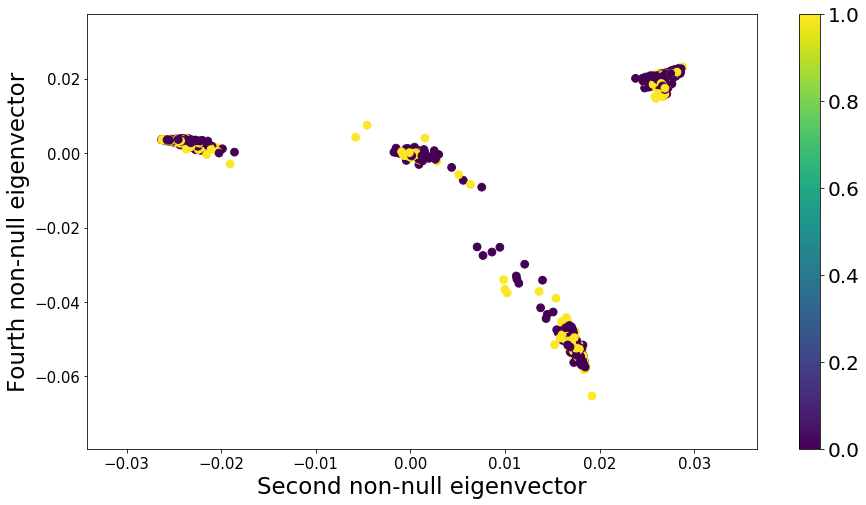

In [121]:
plt.figure(figsize = (15,8))
nodes = nx.draw_networkx_nodes(G, coords, node_size=60, node_color=label_critics)
plt.xlabel("Second non-null eigenvector", size=23)
plt.ylabel("Fourth non-null eigenvector", size=23)
cbar = plt.colorbar(nodes)
cbar.ax.tick_params(labelsize=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.savefig("Figures/graph_metacritic.pdf", bbox_inches="tight")
plt.show()

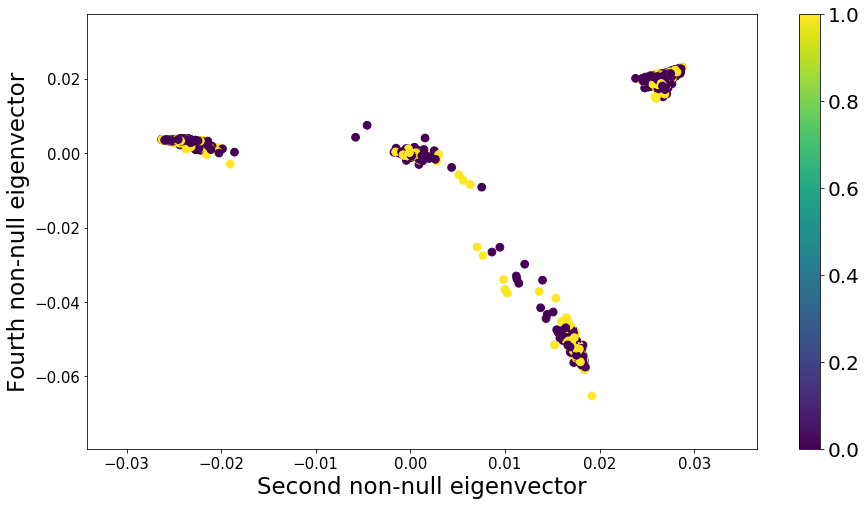

In [122]:
plt.figure(figsize = (15,8))
nodes = nx.draw_networkx_nodes(G, coords, node_size=60, node_color=label_imdb)
plt.xlabel("Second non-null eigenvector", size=23)
plt.ylabel("Fourth non-null eigenvector", size=23)
cbar = plt.colorbar(nodes)
cbar.ax.tick_params(labelsize=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.savefig("Figures/graph_imdb.pdf", bbox_inches="tight")
plt.show()

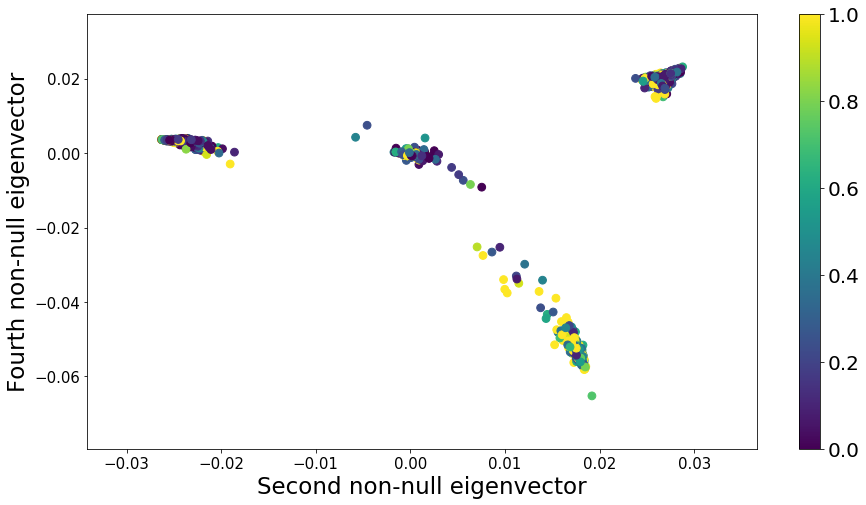

In [123]:
plt.figure(figsize = (15,8))
nodes = nx.draw_networkx_nodes(G, coords, node_size=60, node_color=label_awards)
plt.xlabel("Second non-null eigenvector", size=23)
plt.ylabel("Fourth non-null eigenvector", size=23)
cbar = plt.colorbar(nodes)
cbar.ax.tick_params(labelsize=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.savefig("Figures/graph_wins.pdf", bbox_inches="tight")

plt.show()

## 5.3 Clustering

We used DBSCAN

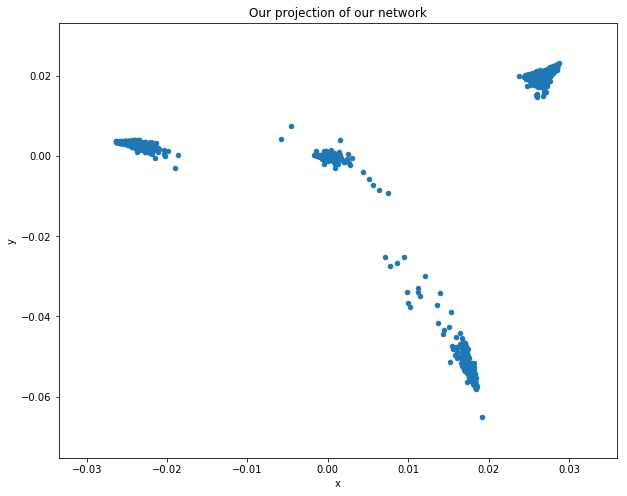

In [124]:
projection_df = pd.DataFrame({'x':coords[:, 0], 'y':coords[:,1]})

projection_df.plot(x = 'x', y = 'y', kind='scatter', figsize=(10, 8), title='Our projection of our network')
plt.show()

In [125]:
def cluster(df, eps=0.3, min_samples=10):
    """Compute and display clusters
    
    Arguments:
    ----------
    df: pandas.DataFrame
        Dataframe containing the needed information.
    eps: float
        Distance to consider for neighbors for the DBSCAN algorithm.
    min_samples: int
        Minimum number of points to consider the set of points as a cluster and no outliers.
    
    Returns:
    ---------
    labels: numpy.ndarray
        The labels associated with each point.
    """
    X = StandardScaler().fit_transform(df)

    # Compute DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    if n_clusters_ > 0:
        if len(list(set(labels))) > 1:
            print("Silhouette Coefficient: %0.3f"
                  % metrics.silhouette_score(X, labels))
        else:
            print("Silhouette Coefficient could not be computed for 1 cluster and 0 noise points")
    else:
        print("Silhouette Coefficient could not be computed for 0 clusters")

    # Plot result
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    plt.figure(figsize=(10,7))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.text(x=0.8, y=-2, s='Range of \n budgets: {5}', size=13)
    plt.text(x=0.6, y=0.7, s='Range of \n budgets: {4}', size=13)
    plt.text(x=-1.1, y=-0.55, s='Range of \n budgets: {3}', size=13)
    plt.text(x=0.25, y=0, s='Range of \n budgets: {1, 2}', size=13)
    plt.xlabel('Second non-null eigenvector', size=14)
    plt.ylabel('Fourth non-null eigenvector', size=14)
    plt.legend(['Cluster 1', '', 'Cluster 2', '', 'Cluster 3', '', 'Cluster 4', ''], prop={'size': 14})
    plt.savefig("Figures/clusters.pdf", bbox_inches="tight")
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.show()
    
    return labels

Estimated number of clusters: 4
Estimated number of noise points: 0
Silhouette Coefficient: 0.941


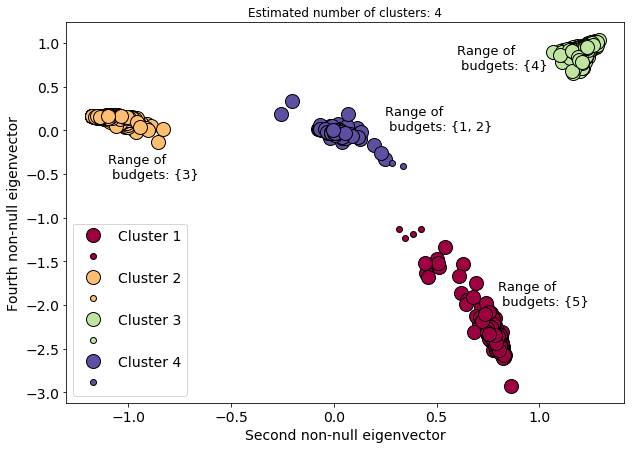

In [126]:
labels = cluster(projection_df, eps=0.35, min_samples=10)

We have 4 distinct clusters. The silhouette coefficient is 0.897 which means the cluster qualities are high (maximum is 1). 

In [127]:
cluster1 = list(np.argwhere(labels==0).flatten())
cluster2 = list(np.argwhere(labels==1).flatten())
cluster3 = list(np.argwhere(labels==2).flatten())
cluster4 = list(np.argwhere(labels==3).flatten())

## 5.4 Cluster analysis

### 1. Analysis of common features

In [128]:
def flatten_set(set_array):
    flattened = []
    for i in range(len(set_array)):
        flattened = flattened + list(set_array[i])
    
    return set(flattened)

In [129]:
def flatten_list(set_array):
    flattened = []
    for i in range(len(set_array)):
        flattened = flattened + list(set_array[i])
    
    return flattened

In [130]:
print('Range of budgets for cluster 1:', set(final_df.loc[cluster1].Budget))
print('Range of budgets for cluster 2:', set(final_df.loc[cluster2].Budget))
print('Range of budgets for cluster 3:', set(final_df.loc[cluster3].Budget))
print('Range of budgets for cluster 4:', set(final_df.loc[cluster4].Budget))

Range of budgets for cluster 1: {5}
Range of budgets for cluster 2: {3}
Range of budgets for cluster 3: {4}
Range of budgets for cluster 4: {1, 2}


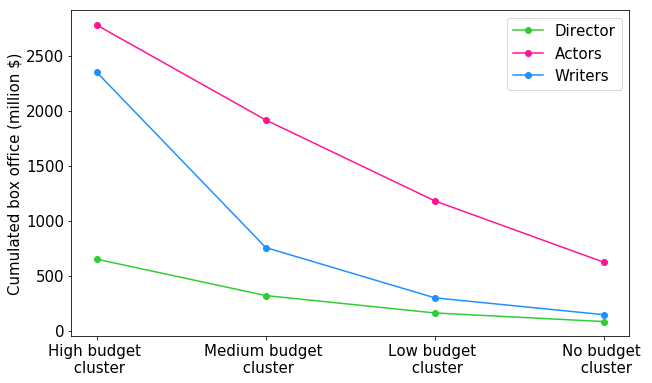

In [146]:
mean_box_directors = [np.mean(final_df.loc[cluster1].BoxOffice_directors.values)/10**6, 
                      np.mean(final_df.loc[cluster3].BoxOffice_directors.values)/10**6, 
                      np.mean(final_df.loc[cluster2].BoxOffice_directors.values)/10**6, 
                      np.mean(final_df.loc[cluster4].BoxOffice_directors.values)/10**6]

mean_box_actors = [np.mean(final_df.loc[cluster1].BoxOffice_actors.values)/10**6, 
                   np.mean(final_df.loc[cluster3].BoxOffice_actors.values)/10**6,
                   np.mean(final_df.loc[cluster2].BoxOffice_actors.values)/10**6, 
                   np.mean(final_df.loc[cluster4].BoxOffice_actors.values)/10**6]

mean_box_writers = [np.mean(final_df.loc[cluster1].BoxOffice_writers.values)/10**6, 
                   np.mean(final_df.loc[cluster3].BoxOffice_writers.values)/10**6, 
                   np.mean(final_df.loc[cluster2].BoxOffice_writers.values)/10**6, 
                   np.mean(final_df.loc[cluster4].BoxOffice_writers.values)/10**6]


x_axis = ['High budget \n cluster', 'Medium budget \n cluster', 'Low budget \n cluster', 'No budget \n cluster']

plt.figure(figsize=(10, 6))
plt.plot(x_axis, mean_box_directors, 'o-', color='limegreen')
plt.plot(x_axis, mean_box_actors, 'o-', color='deeppink')
plt.plot(x_axis, mean_box_writers, 'o-', color='dodgerblue')
plt.ylabel('Cumulated box office (million $)', size=15)
plt.legend(['Director', 'Actors', 'Writers'], prop={'size': 15})
plt.xticks(range(4), x_axis, size=15)
plt.yticks(size=15)
plt.savefig("Figures/featurescrew_results.pdf", bbox_inches="tight")
plt.show()

In [134]:
print('DIRECTORS \n')
print('Directors per film in cluster 1: {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster1].Director.values))/len(final_df.loc[cluster1])))
print('Directors per film in cluster 3: {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster3].Director.values))/len(final_df.loc[cluster3])))
print('Directors per film in cluster 2: {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster2].Director.values))/len(final_df.loc[cluster2])))
print('Directors per film in cluster 4: {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster4].Director.values))/len(final_df.loc[cluster4])))
print(' ')
print("Mean directors' box office per film in cluster 1: {d:.3f} million $".format(d=np.mean(final_df.loc[cluster1].BoxOffice_directors.values)/10**6))
print("Mean directors' box office  per film in cluster 3: {d:.3f} million $".format(d=np.mean(final_df.loc[cluster3].BoxOffice_directors.values)/10**6))
print("Mean directors' box office  per film in cluster 2: {d:.3f} million $".format(d=np.mean(final_df.loc[cluster2].BoxOffice_directors.values)/10**6))
print("Mean directors' box office  per film in cluster 4: {d:.3f} million $".format(d=np.mean(final_df.loc[cluster4].BoxOffice_directors.values)/10**6))
print(' ')
print("Median directors' box office per film in cluster 1: {d:.3f} million $".format(d=np.median(final_df.loc[cluster1].BoxOffice_directors.values)/10**6))
print("Median directors' box office per film in cluster 1: {d:.3f} million $".format(d=np.median(final_df.loc[cluster3].BoxOffice_directors.values)/10**6))
print("Median directors' box office per film in cluster 1: {d:.3f} million $".format(d=np.median(final_df.loc[cluster2].BoxOffice_directors.values)/10**6))
print("Median directors' box office per film in cluster 1: {d:.3f} million $".format(d=np.median(final_df.loc[cluster4].BoxOffice_directors.values)/10**6))

DIRECTORS 

Directors per film in cluster 1: 0.694
Directors per film in cluster 3: 0.716
Directors per film in cluster 2: 0.804
Directors per film in cluster 4: 0.991
 
Mean directors' box office per film in cluster 1: 619.534 million $
Mean directors' box office  per film in cluster 3: 320.268 million $
Mean directors' box office  per film in cluster 2: 156.984 million $
Mean directors' box office  per film in cluster 4: 83.984 million $
 
Median directors' box office per film in cluster 1: 480.433 million $
Median directors' box office per film in cluster 1: 188.091 million $
Median directors' box office per film in cluster 1: 71.122 million $
Median directors' box office per film in cluster 1: 12.861 million $


In [135]:
print('ACTORS \n')
print('Actors per film in cluster 1: {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster1].Actors.values))/len(final_df.loc[cluster1])))
print('Actors per film in cluster 3: {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster3].Actors.values))/len(final_df.loc[cluster3])))
print('Actors per film in cluster 2: {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster2].Actors.values))/len(final_df.loc[cluster2])))
print('Actors per film in cluster 4: {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster4].Actors.values))/len(final_df.loc[cluster4])))
print(' ')
print("Mean actors' box office per film in cluster 1: {d:.3f} million $".format(d=np.mean(final_df.loc[cluster1].BoxOffice_actors.values)/10**6))
print("Mean actors' box office  per film in cluster 3: {d:.3f} million $".format(d=np.mean(final_df.loc[cluster3].BoxOffice_actors.values)/10**6))
print("Mean actors' box office  per film in cluster 2: {d:.3f} million $".format(d=np.mean(final_df.loc[cluster2].BoxOffice_actors.values)/10**6))
print("Mean actors' box office  per film in cluster 4: {d:.3f} million $".format(d=np.mean(final_df.loc[cluster4].BoxOffice_actors.values)/10**6))
print(' ')
print("Median actors' box office per film in cluster 1: {d:.3f} million $".format(d=np.median(final_df.loc[cluster1].BoxOffice_actors.values)/10**6))
print("Median actors' box office per film in cluster 1: {d:.3f} million $".format(d=np.median(final_df.loc[cluster3].BoxOffice_actors.values)/10**6))
print("Median actors' box office per film in cluster 1: {d:.3f} million $".format(d=np.median(final_df.loc[cluster2].BoxOffice_actors.values)/10**6))
print("Median actors' box office per film in cluster 1: {d:.3f} million $".format(d=np.median(final_df.loc[cluster4].BoxOffice_actors.values)/10**6))

ACTORS 

Actors per film in cluster 1: 2.509
Actors per film in cluster 3: 2.369
Actors per film in cluster 2: 2.597
Actors per film in cluster 4: 3.558
 
Mean actors' box office per film in cluster 1: 2778.319 million $
Mean actors' box office  per film in cluster 3: 1915.581 million $
Mean actors' box office  per film in cluster 2: 1180.072 million $
Mean actors' box office  per film in cluster 4: 622.951 million $
 
Median actors' box office per film in cluster 1: 2535.407 million $
Median actors' box office per film in cluster 1: 1756.829 million $
Median actors' box office per film in cluster 1: 971.028 million $
Median actors' box office per film in cluster 1: 300.599 million $


In [136]:
print('WRITERS \n')
print('Writers per film in cluster 1: {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster1].Writer.values))/len(final_df.loc[cluster1])))
print('Writers per film in cluster 3: {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster3].Writer.values))/len(final_df.loc[cluster3])))
print('Writers per film in cluster 2: {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster2].Writer.values))/len(final_df.loc[cluster2])))
print('Writers per film in cluster 4: {d:.3f}'.format(d=len(flatten_set(final_df.loc[cluster4].Writer.values))/len(final_df.loc[cluster4])))
print(' ')
print("Mean writers' box office per film in cluster 1: {d:.3f} million $".format(d=np.mean(final_df.loc[cluster1].BoxOffice_writers.values)/10**6))
print("Mean writers' box office  per film in cluster 3: {d:.3f} million $".format(d=np.mean(final_df.loc[cluster3].BoxOffice_writers.values)/10**6))
print("Mean writers' box office  per film in cluster 2: {d:.3f} million $".format(d=np.mean(final_df.loc[cluster2].BoxOffice_writers.values)/10**6))
print("Mean writers' box office  per film in cluster 4: {d:.3f} million $".format(d=np.mean(final_df.loc[cluster4].BoxOffice_writers.values)/10**6))
print(' ')
print("Median writers' box office per film in cluster 1: {d:.3f} million $".format(d=np.median(final_df.loc[cluster1].BoxOffice_writers.values)/10**6))
print("Median writers' box office per film in cluster 1: {d:.3f} million $".format(d=np.median(final_df.loc[cluster3].BoxOffice_writers.values)/10**6))
print("Median writers' box office per film in cluster 1: {d:.3f} million $".format(d=np.median(final_df.loc[cluster2].BoxOffice_writers.values)/10**6))
print("Median writers' box office per film in cluster 1: {d:.3f} million $".format(d=np.median(final_df.loc[cluster4].BoxOffice_writers.values)/10**6))

WRITERS 

Writers per film in cluster 1: 2.225
Writers per film in cluster 3: 2.069
Writers per film in cluster 2: 1.828
Writers per film in cluster 4: 1.724
 
Mean writers' box office per film in cluster 1: 2349.947 million $
Mean writers' box office  per film in cluster 3: 756.515 million $
Mean writers' box office  per film in cluster 2: 299.575 million $
Mean writers' box office  per film in cluster 4: 146.418 million $
 
Median writers' box office per film in cluster 1: 1408.369 million $
Median writers' box office per film in cluster 1: 435.724 million $
Median writers' box office per film in cluster 1: 149.236 million $
Median writers' box office per film in cluster 1: 21.277 million $


In [137]:
print('GENRES \n')
print('Genres not in cluster 1 (high budget):', flatten_set(final_df.Genre.values) - flatten_set(final_df.loc[cluster1].Genre.values))
print('Genres not in cluster 3 (medium budget):', flatten_set(final_df.Genre.values) - flatten_set(final_df.loc[cluster3].Genre.values))
print('Genres not in cluster 2 (low budget):', flatten_set(final_df.Genre.values) - flatten_set(final_df.loc[cluster2].Genre.values))
print('Genres not in cluster 4 (independent):', flatten_set(final_df.Genre.values) - flatten_set(final_df.loc[cluster4].Genre.values))
print(' ')
print('5 most common genres in cluster 1:', list(pd.DataFrame(flatten_list(final_df.loc[cluster1].Genre.values))[0].value_counts()[:5].index))
print('5 most common genres in cluster 3:', list(pd.DataFrame(flatten_list(final_df.loc[cluster3].Genre.values))[0].value_counts()[:5].index))
print('5 most common genres in cluster 2:', list(pd.DataFrame(flatten_list(final_df.loc[cluster2].Genre.values))[0].value_counts()[:5].index))
print('5 most common genres in cluster 4:', list(pd.DataFrame(flatten_list(final_df.loc[cluster4].Genre.values))[0].value_counts()[:5].index))

GENRES 

Genres not in cluster 1 (high budget): {'News'}
Genres not in cluster 3 (medium budget): {'News'}
Genres not in cluster 2 (low budget): set()
Genres not in cluster 4 (independent): {'News'}
 
5 most common genres in cluster 1: ['Adventure', 'Action', 'Sci-Fi', 'Fantasy', 'Family']
5 most common genres in cluster 3: ['Drama', 'Comedy', 'Thriller', 'Action', 'Adventure']
5 most common genres in cluster 2: ['Drama', 'Comedy', 'Thriller', 'Romance', 'Crime']
5 most common genres in cluster 4: ['Drama', 'Comedy', 'Thriller', 'Romance', 'Crime']


In [138]:
genre1 = pd.DataFrame(flatten_list(final_df.loc[cluster1].Genre.values))[0].value_counts()[:5]/208
genre3 = pd.DataFrame(flatten_list(final_df.loc[cluster3].Genre.values))[0].value_counts()[:5]/247
genre2 = pd.DataFrame(flatten_list(final_df.loc[cluster2].Genre.values))[0].value_counts()[:5]/466
genre4 = pd.DataFrame(flatten_list(final_df.loc[cluster4].Genre.values))[0].value_counts()[:5]/229

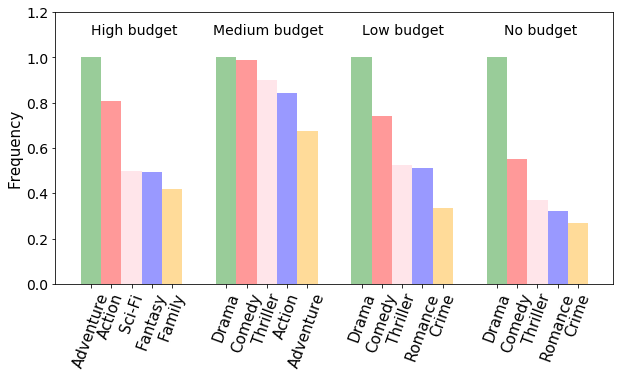

In [147]:
n_groups = 4

first = (1, 1, 1, 1)
second = (0.807, 0.99, 0.74, 0.55)
third = (0.5, 0.902, 0.527, 0.371)
fourth = (0.495, 0.842, 0.511, 0.323)
fifth = (0.418, 0.676, 0.335, .271)
bar_width = 0.6

fig, ax = plt.subplots(figsize=(10, 5))
index = 4*np.arange(n_groups)
idx_names = np.sort(list(index) + list(index + bar_width) + list(index + 2*bar_width) + 
                    list(index + 3*bar_width) + list(index + 4*bar_width))


opacity = 0.4

rects1 = plt.bar(index, first, bar_width,
                 alpha=opacity,
                 color='green')

rects2 = plt.bar(index + bar_width, second, bar_width,
                 alpha=opacity,
                 color='red')

rects2 = plt.bar(index + 2*bar_width, third, bar_width,
                 alpha=opacity,
                 color='pink')

rects2 = plt.bar(index + 3*bar_width, fourth, bar_width,
                 alpha=opacity,
                 color='blue')

rects2 = plt.bar(index + 4*bar_width, fifth, bar_width,
                 alpha=opacity,
                 color='orange')

plt.ylabel('Frequency', size=15)
#plt.title('Five most frequent genres by cluster', size=18)
plt.xticks(idx_names, ('Adventure', 'Action', 'Sci-Fi', 'Fantasy', 'Family',
                       'Drama', 'Comedy', 'Thriller', 'Action', 'Adventure', 
                       'Drama', 'Comedy', 'Thriller', 'Romance', 'Crime', 
                       'Drama', 'Comedy', 'Thriller', 'Romance', 'Crime'), rotation=70, size=15)
plt.text(x = 0, y = 1.1, s='High budget', size=14)
plt.text(x = 3.6, y = 1.1, s='Medium budget', size=14)
plt.text(x = 8., y = 1.1, s='Low budget', size=14)
plt.text(x = 12.2, y = 1.1, s='No budget', size=14)
ax.set_ylim(0, 1.2)
plt.yticks(size=14)
plt.savefig('Figures/genres.pdf', bbox_inches="tight")
plt.show()

In [140]:
print('PLOT \n')
print('10 most common plot words in cluster 1:', list(pd.DataFrame(flatten_list(final_df.loc[cluster1].Plot.values))[0].value_counts()[:10].index))
print('10 most common plot words in cluster 3:', list(pd.DataFrame(flatten_list(final_df.loc[cluster3].Plot.values))[0].value_counts()[:10].index))
print('10 most common plot words in cluster 2:', list(pd.DataFrame(flatten_list(final_df.loc[cluster2].Plot.values))[0].value_counts()[:10].index))
print('10 most common plot words in cluster 4:', list(pd.DataFrame(flatten_list(final_df.loc[cluster4].Plot.values))[0].value_counts()[:10].index))

PLOT 

10 most common plot words in cluster 1: ['world', 'life', 'home', 'time', 'team', 'friends', 'help', 'war', 'race', 'man']
10 most common plot words in cluster 3: ['life', 'man', 'world', 'woman', 'family', 'team', 'love', 'group', 'father', 'wife']
10 most common plot words in cluster 2: ['life', 'man', 'woman', 'family', 'school', 'story', 'friends', 'girl', 'world', 'years']
10 most common plot words in cluster 4: ['family', 'life', 'woman', 'man', 'mother', 'story', 'friends', 'love', 'world', 'group']


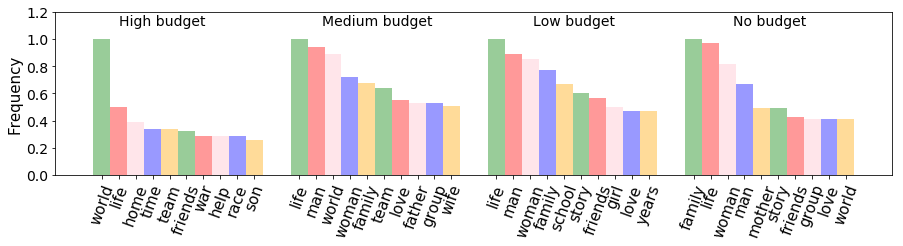

In [141]:
n_groups = 4

first = (1, 1, 1, 1)
second = (0.5, 0.94, 0.89, 0.97)
third = (0.39, 0.89, 0.85, 0.82)
fourth = (0.34, 0.72, 0.77, 0.67)
fifth = (0.34, 0.68, 0.67, 0.49)
sixth = (0.32, 0.64, 0.6, 0.49)
seventh = (0.29, 0.55, 0.57, 0.43)
eighth = (0.29, 0.53, 0.5, 0.41)
ninth = (0.29, 0.53, 0.47, 0.41)
tenth = (0.26, 0.51, 0.47, 0.41)

bar_width = 0.6

fig, ax = plt.subplots(figsize=(15, 3))
index = 7*np.arange(n_groups)
idx_names = np.sort(list(index) + list(index + bar_width) + list(index + 2*bar_width) + 
                    list(index + 3*bar_width) + list(index + 4*bar_width) + list(index + 5*bar_width) +
                    list(index + 6*bar_width) + list(index + 7*bar_width) + list(index + 8*bar_width) + 
                    list(index + 9*bar_width))

opacity = 0.4

rects1 = plt.bar(index, first, bar_width,
                 alpha=opacity,
                 color='green')

rects2 = plt.bar(index + bar_width, second, bar_width,
                 alpha=opacity,
                 color='red')

rects3 = plt.bar(index + 2*bar_width, third, bar_width,
                 alpha=opacity,
                 color='pink')

rects4 = plt.bar(index + 3*bar_width, fourth, bar_width,
                 alpha=opacity,
                 color='blue')

rects5 = plt.bar(index + 4*bar_width, fifth, bar_width,
                 alpha=opacity,
                 color='orange')

rects6 = plt.bar(index+ 5*bar_width, sixth, bar_width,
                 alpha=opacity,
                 color='green')

rects7 = plt.bar(index + 6*bar_width, seventh, bar_width,
                 alpha=opacity,
                 color='red')

rects8 = plt.bar(index + 7*bar_width, eighth, bar_width,
                 alpha=opacity,
                 color='pink')

rects9 = plt.bar(index + 8*bar_width, ninth, bar_width,
                 alpha=opacity,
                 color='blue')

rects10 = plt.bar(index + 9*bar_width, tenth, bar_width,
                 alpha=opacity,
                 color='orange')

plt.ylabel('Frequency', size=15)
#plt.title('Ten most frequent genres by cluster', size=18)
plt.xticks(idx_names, ('world', 'life', 'home', 'time', 'team', 'friends', 'war', 'help', 'race', 'son', 
                       'life', 'man', 'world', 'woman', 'family', 'team', 'love', 'father', 'group', 'wife',
                       'life', 'man', 'woman', 'family', 'school', 'story', 'friends', 'girl','love', 'years', 
                       'family', 'life', 'woman', 'man', 'mother', 'story', 'friends', 'group', 'love', 'world'),
           rotation=70, size=15)
plt.text(x = 0.6, y = 1.1, s='High budget', size=14)
plt.text(x = 7.8, y = 1.1, s='Medium budget', size=14)
plt.text(x = 15.3, y = 1.1, s='Low budget', size=14)
plt.text(x = 22.4, y = 1.1, s='No budget', size=14)
plt.yticks(size=14)
ax.set_ylim(0, 1.2)
plt.savefig('Figures/words.pdf', bbox_inches="tight")
plt.show()

### 2. Analysis of labels

In [142]:
print('Mean box office for cluster 1: {d:.3f}'.format(d=np.mean(label_boxoffice[cluster1])))
print('Mean box office for cluster 3: {d:.3f}'.format(d=np.mean(label_boxoffice[cluster3])))
print('Mean box office for cluster 2: {d:.3f}'.format(d=np.mean(label_boxoffice[cluster2])))
print('Mean box office for cluster 4: {d:.3f}'.format(d=np.mean(label_boxoffice[cluster4])))
print(' ')
print('Median box office for cluster 1: {d:.3f}'.format(d=np.median(label_boxoffice[cluster1])))
print('Median box office for cluster 3: {d:.3f}'.format(d=np.median(label_boxoffice[cluster3])))
print('Median box office for cluster 2: {d:.3f}'.format(d=np.median(label_boxoffice[cluster2])))
print('Median box office for cluster 4: {d:.3f}'.format(d=np.median(label_boxoffice[cluster4])))

Mean box office for cluster 1: 0.924
Mean box office for cluster 3: 0.673
Mean box office for cluster 2: 0.387
Mean box office for cluster 4: 0.160
 
Median box office for cluster 1: 1.000
Median box office for cluster 3: 0.727
Median box office for cluster 2: 0.308
Median box office for cluster 4: 0.053


In [143]:
print('Mean critics grade for cluster 1: {d:.3f}'.format(d=np.mean(label_critics[cluster1])))
print('Mean critics grade for cluster 3: {d:.3f}'.format(d=np.mean(label_critics[cluster3])))
print('Mean critics grade for cluster 2: {d:.3f}'.format(d=np.mean(label_critics[cluster2])))
print('Mean critics grade for cluster 4: {d:.3f}'.format(d=np.mean(label_critics[cluster4])))
print(' ')
print('Median critics grade for cluster 1: {d:.3f}'.format(d=np.median(label_critics[cluster1])))
print('Median critics grade for cluster 3: {d:.3f}'.format(d=np.median(label_critics[cluster3])))
print('Median critics grade for cluster 2: {d:.3f}'.format(d=np.median(label_critics[cluster2])))
print('Median critics grade for cluster 4: {d:.3f}'.format(d=np.median(label_critics[cluster4])))

Mean critics grade for cluster 1: 0.494
Mean critics grade for cluster 3: 0.314
Mean critics grade for cluster 2: 0.396
Mean critics grade for cluster 4: 0.605
 
Median critics grade for cluster 1: 0.000
Median critics grade for cluster 3: 0.000
Median critics grade for cluster 2: 0.000
Median critics grade for cluster 4: 1.000


In [144]:
print('Mean imdb grade for cluster 1: {d:.3f}'.format(d=np.mean(label_imdb[cluster1])))
print('Mean imdb grade for cluster 3: {d:.3f}'.format(d=np.mean(label_imdb[cluster3])))
print('Mean imdb grade for cluster 2: {d:.3f}'.format(d=np.mean(label_imdb[cluster2])))
print('Mean imdb grade for cluster 4: {d:.3f}'.format(d=np.mean(label_imdb[cluster4])))
print(' ')
print('Median imdb grade for cluster 1: {d:.3f}'.format(d=np.median(label_imdb[cluster1])))
print('Median imdb grade for cluster 3: {d:.3f}'.format(d=np.median(label_imdb[cluster3])))
print('Median imdb grade for cluster 2: {d:.3f}'.format(d=np.median(label_imdb[cluster2])))
print('Median imdb grade for cluster 4: {d:.3f}'.format(d=np.median(label_imdb[cluster4])))

Mean imdb grade for cluster 1: 0.472
Mean imdb grade for cluster 3: 0.314
Mean imdb grade for cluster 2: 0.381
Mean imdb grade for cluster 4: 0.531
 
Median imdb grade for cluster 1: 0.000
Median imdb grade for cluster 3: 0.000
Median imdb grade for cluster 2: 0.000
Median imdb grade for cluster 4: 1.000


In [145]:
print('Mean awards for cluster 1: {d:.3f}'.format(d=np.mean(label_awards[cluster1])))
print('Mean awards for cluster 3: {d:.3f}'.format(d=np.mean(label_awards[cluster3])))
print('Mean awards for cluster 2: {d:.3f}'.format(d=np.mean(label_awards[cluster2])))
print('Mean iawards for cluster 4: {d:.3f}'.format(d=np.mean(label_awards[cluster4])))
print(' ')
print('Median awards for cluster 1: {d:.3f}'.format(d=np.median(label_awards[cluster1])))
print('Median awards for cluster 3: {d:.3f}'.format(d=np.median(label_awards[cluster3])))
print('Median awards for cluster 2: {d:.3f}'.format(d=np.median(label_awards[cluster2])))
print('Median awards for cluster 4: {d:.3f}'.format(d=np.median(label_awards[cluster4])))

Mean awards for cluster 1: 0.730
Mean awards for cluster 3: 0.412
Mean awards for cluster 2: 0.368
Mean iawards for cluster 4: 0.484
 
Median awards for cluster 1: 0.931
Median awards for cluster 3: 0.276
Median awards for cluster 2: 0.207
Median awards for cluster 4: 0.345


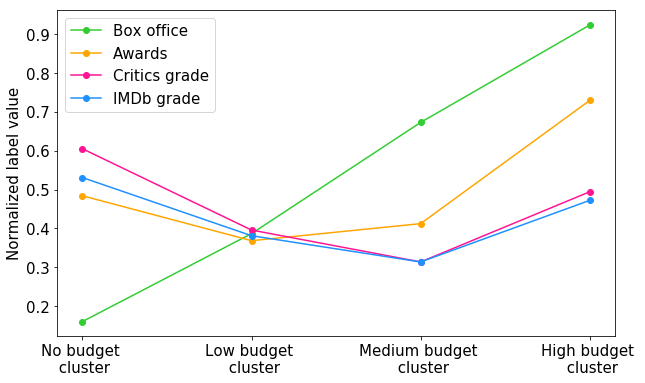

In [145]:
mean_box = [np.mean(label_boxoffice[cluster4]), np.mean(label_boxoffice[cluster2]), 
            np.mean(label_boxoffice[cluster3]), np.mean(label_boxoffice[cluster1])]
mean_awards = [np.mean(label_awards[cluster4]), np.mean(label_awards[cluster2]), 
               np.mean(label_awards[cluster3]),np.mean(label_awards[cluster1])]
mean_critics = [np.mean(label_critics[cluster4]), np.mean(label_critics[cluster2]),
                np.mean(label_critics[cluster3]), np.mean(label_critics[cluster1])]
mean_imdb = [np.mean(label_imdb[cluster4]), np.mean(label_imdb[cluster2]), 
             np.mean(label_imdb[cluster3]), np.mean(label_imdb[cluster1])]


x_axis = ['No budget \n cluster', 'Low budget \n cluster', 'Medium budget \n cluster', 'High budget \n cluster']

plt.figure(figsize=(10, 6))
plt.plot(x_axis, mean_box, 'o-', color='limegreen')
plt.plot(x_axis, mean_awards, 'o-', color='orange')
plt.plot(x_axis, mean_critics, 'o-', color='deeppink')
plt.plot(x_axis, mean_imdb, 'o-', color='dodgerblue')
plt.ylabel('Normalized label value', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(['Box office', 'Awards', 'Critics grade', 'IMDb grade'], prop={'size': 15})
#plt.title('Mean label value for each cluster', size=18)
plt.savefig("Figures/labels_results.pdf", bbox_inches="tight")
plt.show()